## 1. Camera Calibration
#### getting image points and object points

In [1]:
# Camera calibration 
# To find distortion co-efficients

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

calib_images = glob.glob('./camera_cal/calibration*.jpg')

#img = mpimg.imread('./camera_cal/calibration1.jpg')#ret -> False
#img = mpimg.imread('./camera_cal/calibration2.jpg')#ret -> False

#plt.imshow(img)
nx = 9
ny = 6
objpoints = []
imgpoints =[]
objpt = np.zeros((ny*nx,3),np.float32)
#print(objpt)

# Chess board corner co-ordinates in 3D
objpt[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
#print(objpt)

for f_name in calib_images:
    img = mpimg.imread(f_name)
    #Converting to gray for better corner detection
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(gray,cmap = 'gray')

    # Finding Corners on chessboard
    ret,corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print(ret)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objpt)
        #displaying corners
        #img = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
        #plt.imshow(img)


In [ ]:
#print(len(objpoints))
#print(imgpoints)

In [2]:
# Camera Calibration
def Calibrate_camera(objpoints,imgpoints):
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

ret,mtx,dist,rvecs,tvecs = Calibrate_camera(objpoints,imgpoints)
print(mtx)


[[  1.15290556e+03   0.00000000e+00   6.66492186e+02]
 [  0.00000000e+00   1.14676266e+03   3.86574197e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


## 2. Reading an image and undistorting it

In [3]:
# Reading a road image with lane lines
rd_img = mpimg.imread('./test_images/test2.jpg')
#rd_img = mpimg.imread('./camera_cal/calibration2.jpg')
print(rd_img.shape)
# Undistorting the test image
def undistort_img(rd_img):
    dst = cv2.undistort(rd_img,mtx,dist)
    #plt.imshow(dst)
    return dst


(720, 1280, 3)


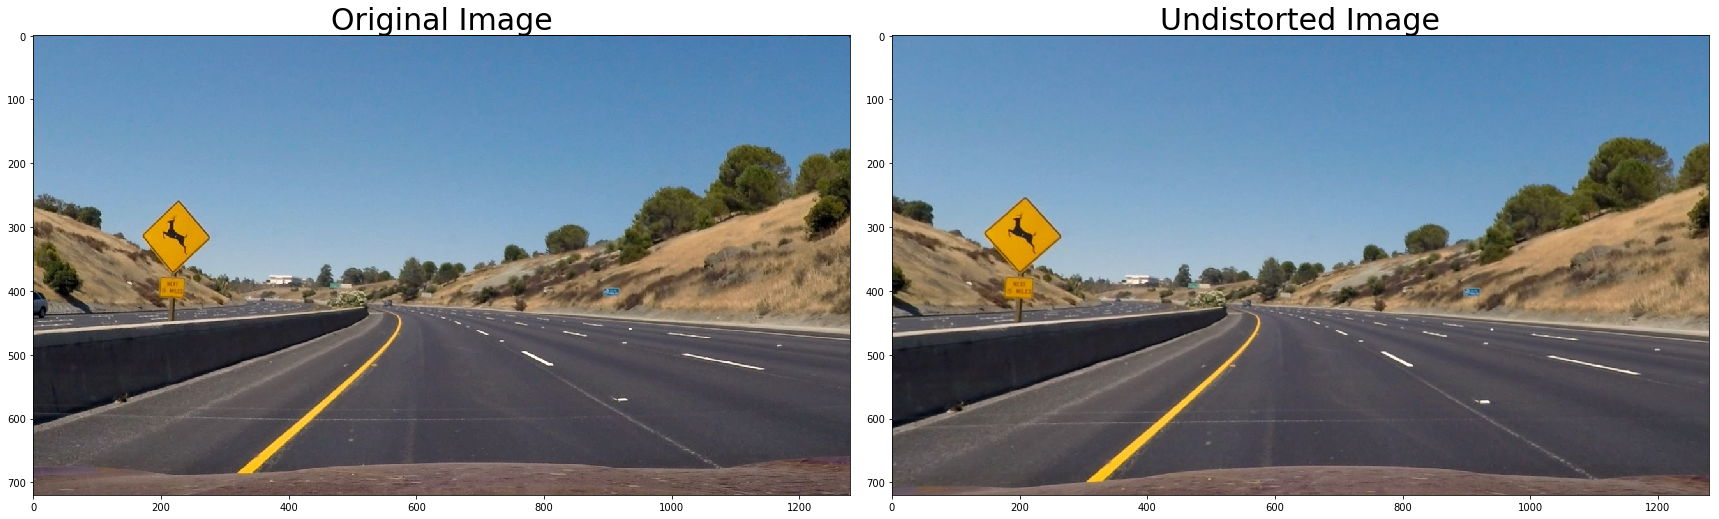

In [5]:
#Subplot Initialization to demo pipeline
f,(ax1,ax2) = plt.subplots(1,2,figsize = (24,9))
f.tight_layout()
#Plotting all the original and undstorted images on subplot
ax1.imshow(rd_img)
ax1.set_title('Original Image',fontsize=30)
undist_img = undistort_img(rd_img)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image',fontsize=30)

## 3. Color map ,Sobel edge detection and perspective transform

#### Color map thresholding

In [4]:
def sobel_with_color_chnl(rd_img):
    #Grayscale image of undistorted image
    undist_img = undistort_img(rd_img)
    rd_gray = cv2.cvtColor(undist_img,cv2.COLOR_RGB2GRAY)
    #plt.imshow(l_gray,cmap = 'gray')
    

    sobel_kernel = 3
    thres_min = 20
    thres_max = 180

    sobelx = cv2.Sobel(rd_gray,cv2.CV_64F,1,0)
    abs_sobelx = np.absolute(sobelx)

    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thres_min) & (scaled_sobel <= thres_max)] = 1
    sobel_binary_output = np.copy(sybinary)
    #plt.imshow(sobel_binary_output,cmap='gray')
    #print(sobel_binary_output.shape)

    hls_img = cv2.cvtColor(undist_img,cv2.COLOR_RGB2HLS)
    # Choosing Saturation channel for gradient
    s_channel = hls_img[:,:,2]
    #plt.imshow(ls_img)
    l_channel = hls_img[:,:,1]
    #plt.imshow(ls_img,cmap = 'gray')
    #thres = (150,255)
    thres = (120,140)
    
    binary_s = np.zeros_like(s_channel)
    binary_s[(l_channel > thres[0]) & (s_channel > thres[1])] =1
    #plt.imshow(binary_s,cmap = 'gray')

    binary_image = sobel_binary_output | binary_s
    #plt.imshow(binary_image,cmap = 'gray')
    
    return binary_image

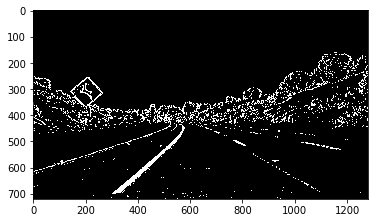

In [5]:
binary_image = sobel_with_color_chnl(rd_img)
plt.imshow(binary_image,cmap = 'gray')

##### defining region of interest
##### v1 = [0,720] v2 = [1280,720] apx = [700,400]

In [6]:
def roi_masked_img(binary_image):
    pv1 = np.array([[[100,720],[600,400],[800,400],[1200,720]]],dtype= np.int32)
    mask_img = np.zeros_like(binary_image)
    cv2.fillPoly(mask_img,pv1,1)

    binary_output = binary_image & mask_img
    return binary_output
    

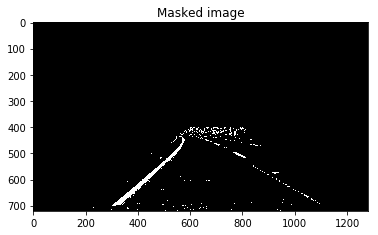

In [7]:
binary_output = roi_masked_img(binary_image)
plt.imshow(binary_output,cmap='gray')
plt.title('Masked image')

#### Perspective image for the masked image

In [15]:
def perspec_matrix(binary_output):
    src_pts = np.float32([[590,450],[695,450],[1090,680],[230,680]])
    dst_pts = np.float32([[300,0],[950,0],[950,719],[300,719]])
    #Compute the perspective transform M
    M = cv2.getPerspectiveTransform(src_pts,dst_pts)
    #Compute the inverse perspective transform Minv
    Minv = cv2.getPerspectiveTransform(dst_pts,src_pts)
    # Create warped image using linear interpolation
    return M,Minv
def warped_img(binary_output):
    img_size = (binary_output.shape[1],binary_output.shape[0])
    warped_img = cv2.warpPerspective(binary_output,M,img_size,flags = cv2.INTER_LINEAR)
    return warped_img


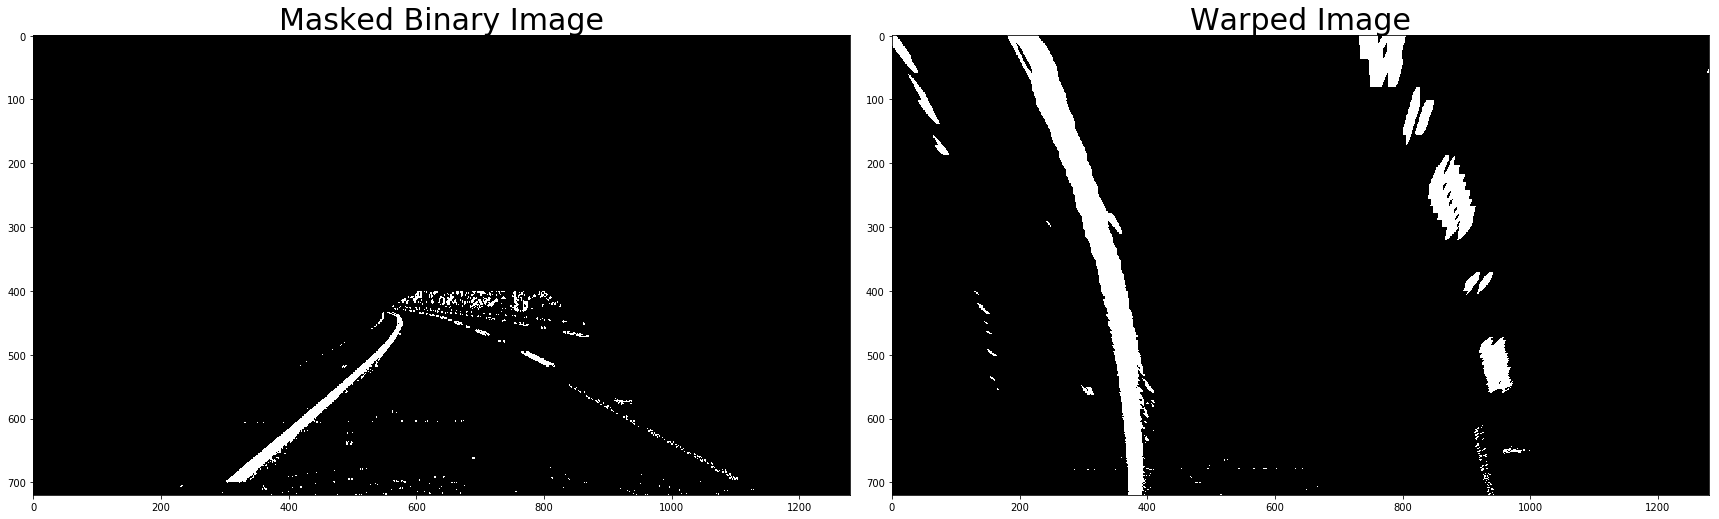

In [11]:
#Subplot Initialization for pileline demo
f,(ax1,ax2) = plt.subplots(1,2,figsize = (24,9))
f.tight_layout()
#Plotting all the original and undstorted images on subplot
ax1.imshow(binary_output,cmap='gray')
ax1.set_title('Masked Binary Image',fontsize=30)

M,Minv = perspec_matrix(binary_output)

# warped_img = warped_img(rd_img)
warped_img = warped_img(binary_output)
ax2.imshow(warped_img,cmap='gray')
ax2.set_title('Warped Image',fontsize=30)

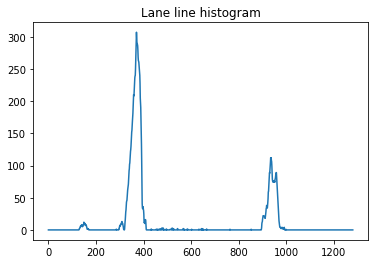

In [12]:
# Draw histogram of warped image
def plot_histogram(h_img):
    return np.sum(h_img[h_img.shape[0]//2:,:],axis = 0)

persp_img = np.copy(warped_img)
histogram = plot_histogram(persp_img)
plt.title('Lane line histogram')
plt.plot(histogram)

#### finding lane lines through sliding window 
###### In a perspective image

In [13]:
# to draw lane lines polynomial and filling the polynomial
class Lanefill():
    def __init__(self):
        self.lane_coeff =[]
    def draw_lane_polynomials(self,rd_img):

        bin_image = sobel_with_color_chnl(rd_img)
        roi_bin_image = roi_masked_img(bin_image)
        persp_img = warped_img(roi_bin_image)

        binary_warp = np.copy(persp_img)
        
        # Create a depth 3 output image to draw and visualize lane lines
        out_img = np.dstack((binary_warp,binary_warp,binary_warp))*255
        #plt.imshow(out_img)
        # Identify all non-zero pixels im warped image
        nonzero = binary_warp.nonzero()

        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # margin of width for window
        margin = 100
        # minimum number of pixel in window to recentre window
        minpix = 50
        
        # taking a histogram of half of the image
        histogram = plot_histogram(binary_warp)
        # Finding left and right lane points on x-axis
        # these will be starting point of window
        midpoint = np.int(histogram.shape[0]//2)
        #print(midpoint)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[:midpoint]) + midpoint
        print(leftx_base,rightx_base)
        
        
        if len(self.lane_coeff) == 0:

            # Number of windows
            nwindows = 9
            window_height = np.int(binary_warp.shape[0]//nwindows)
            print(window_height)

#             # Identify all non-zero pixels im warped image
#             nonzero = binary_warp.nonzero()

#             nonzeroy = np.array(nonzero[0])
#             nonzerox = np.array(nonzero[1])
#             # margin of width for window
#             margin = 100
#             # minimum number of pixel in window to recentre window
#             minpix = 50

            #Empty list for left and right lane points
            left_lane_inds = []
            right_lane_inds = []

            #Iterating through windows
            for window in range(nwindows):#nwindows
                # window co-ords for left and right lane window
                win_y_low = binary_warp.shape[0] - (window+1)*window_height
                win_y_high = binary_warp.shape[0] - (window)*window_height
                win_xleft_low = leftx_base - margin
                win_xleft_high = leftx_base + margin
                win_xright_low = rightx_base - margin
                win_xright_high = rightx_base + margin
                #print(win_y_low,win_y_high)
                #print(win_xleft_low,win_xleft_high,win_xright_low,win_xright_high)

                # Identify non-zero pixels inside window from warped image
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high) & (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)).nonzero()[0]

                # Append indices to list
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If we find #pixels > minpix we need to recentre window to the mean of window x'co-ords
                if len(good_left_inds) > minpix:
                    leftx_base = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:
                    rightx_base = np.int(np.mean(nonzerox[good_right_inds]))

            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

            # Extract left and right pixel co-ords
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]

            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
        else:
            # Skipping the windowing part
            prev_left_lane_coeff = self.lane_coeff[-1][0]
            prev_right_lane_coeff = self.lane_coeff[-1][1]
            
            # Line window with offset
            left_lane_inds = ((nonzerox > (prev_left_lane_coeff[0] * (nonzeroy ** 2) + prev_left_lane_coeff[1] * nonzeroy + prev_left_lane_coeff[2] - margin)) 
                              & (nonzerox < (prev_left_lane_coeff[0] * (nonzeroy ** 2) + prev_left_lane_coeff[1] * nonzeroy + prev_left_lane_coeff[2] + margin)))
            
            right_lane_inds = ((nonzerox > (prev_right_lane_coeff[0] * (nonzeroy ** 2) + prev_right_lane_coeff[1] * nonzeroy + prev_right_lane_coeff[2] - margin)) 
                              & (nonzerox < (prev_right_lane_coeff[0] * (nonzeroy ** 2) + prev_right_lane_coeff[1] * nonzeroy + prev_right_lane_coeff[2] + margin)))
            
            # Extract left and right pixel co-ords
            leftx = nonzerox[left_lane_inds]
            lefty = nonzeroy[left_lane_inds]

            rightx = nonzerox[right_lane_inds]
            righty = nonzeroy[right_lane_inds]
            
        # Fit a 2nd order polynomial for left and right lanes
        left_fit = np.polyfit(lefty,leftx,2)
        right_fit = np.polyfit(righty,rightx,2)
        #print(left_fit,right_fit)
        
        # Adding line co efficients to global list for averaging or smoothening of line
        # Allowed #windows 10
        if len(self.lane_coeff) < 10:
            self.lane_coeff.append([left_fit.tolist(),right_fit.tolist()])
        else:
            self.lane_coeff = self.lane_coeff[1:]
            self.lane_coeff.append([left_fit.tolist(),right_fit.tolist()])
            
        # Taking averaged co-eff for the lane line for smoothening(if needed)
        la,lb,lc = 0,0,0
        ra,rb,rc = 0,0,0
        n_frames = len(self.lane_coeff)
        for ele in self.lane_coeff:
            # left lane co-eff
            la += ele[0][0]
            lb += ele[0][1]
            lc += ele[0][2]
            # Right lane co-eff
            ra += ele[1][0]
            rb += ele[1][1]
            rc += ele[1][2]
        n_left_lane_coeff = [la/n_frames,lb/n_frames,lc/n_frames]
        n_right_lane_coeff = [ra/n_frames,rb/n_frames,rc/n_frames]
        
        left_fit = n_left_lane_coeff
        right_fit = n_right_lane_coeff
        
        # lane pixel points 
        ploty = np.linspace(0,binary_warp.shape[0]-1,binary_warp.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        ##############################################################
        # for writeup
        #binary_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        #binary_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
#         plt.plot(left_fitx, ploty, color='red')
#         plt.plot(right_fitx, ploty, color='red')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
        
        ##############################################################
        # Calculation of Radious of curvature and Centre offset
        ##############################################################
        
        # Coversion factor for pixel to meter (In meter per pixel along the axis)
        ym_per_pixel = 30/720
        xm_per_pixel = 3.7/700
        # fit the polynomial in meter space
        left_fit_mtr = np.polyfit(ploty * ym_per_pixel, left_fitx * xm_per_pixel,2)
        right_fit_mtr = np.polyfit(ploty * ym_per_pixel, right_fitx * xm_per_pixel,2)
        
        y_eval = np.max(ploty)
        left_curve_rad = ((1+(2*left_fit_mtr[0]*y_eval*ym_per_pixel + left_fit_mtr[1] )**2)**1.5)/(np.absolute(2*left_fit_mtr[0]))
        right_curve_rad = ((1+(2*right_fit_mtr[0]*y_eval*ym_per_pixel + right_fit_mtr[1] )**2)**1.5)/(np.absolute(2*right_fit_mtr[0]))
        
        # 2 for mean 
        lane_curvature = (left_curve_rad + right_curve_rad)/2
        
        #Center offset calculation
        
#         #Polynomial approach
#         lane_center = rd_img.shape[0]//2
#         bottom_y_pt = rd_img.shape[0] -1
#         #print(bottom_y_pt)
#         left_lane_bt_pt = left_fit[0]*bottom_y_pt**2 + left_fit[1]*bottom_y_pt + left_fit[2]
#         print(left_lane_bt_pt)
#         right_lane_bt_pt = right_fit[0]*bottom_y_pt**2 + right_fit[1]*bottom_y_pt + right_fit[2]
#         print(right_lane_bt_pt)

#         # Histogram Approach
        lane_center,left_lane_bt_pt,right_lane_bt_pt = midpoint,leftx_base,rightx_base
        
        calc_lane_centre = left_lane_bt_pt + (right_lane_bt_pt - left_lane_bt_pt)//2
        print(calc_lane_centre)
        
        # negative : right positive : left
        center_offset = (lane_center - calc_lane_centre)*xm_per_pixel
        
        ##############################################################
        
        blank_img = np.zeros_like(persp_img)
        blank_img_lane = np.dstack((blank_img,blank_img,blank_img))
        #print(blank_img_lane.shape)

        #plt.imshow(blank_img,cmap = 'gray')
    #     plt.plot(left_fitx,ploty,color = 'yellow')
    #     plt.plot(right_fitx,ploty,color = 'yellow')
    #     plt.xlim(0, 1280)
    #     plt.ylim(720, 0)

        # coloring window detected pixels
    #     out_img[nonzeroy[left_lane_inds],nonzerox[left_lane_inds]] = [255,0,0]
    #     out_img[nonzeroy[right_lane_inds],nonzerox[right_lane_inds]] = [0,0,255]

        # Fill color between lane lines
        left_lane_poly_pts = np.array([np.transpose(np.vstack([left_fitx,ploty]))])
        right_lane_poly_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
        poly_points = np.hstack((left_lane_poly_pts,right_lane_poly_pts))

        cv2.fillPoly(blank_img_lane,np.int_([poly_points]),[0,255,0])

        # Inverse perspective transformation
        b_img_size = (blank_img_lane.shape[1],blank_img_lane.shape[0])
        unwarped_lane_area = cv2.warpPerspective(blank_img_lane,Minv,b_img_size,flags = cv2.INTER_LINEAR)

        img_lane_area_org = cv2.addWeighted(rd_img,1,unwarped_lane_area,0.3,0)
        #plt.imshow(img_lane_area_org)
        toward = 'left' if center_offset >= 0 else 'right'
        cv2.putText(img_lane_area_org,'Vehicle is {0:.2f} m '.format(abs(center_offset))+' '+toward+' of center',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        cv2.putText(img_lane_area_org,'Radius of curvature = {0:.2f} m '.format(lane_curvature),(50,50),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
        #print(len(self.lane_coeff))
        
        #return binary_warp for testing
        return img_lane_area_org
    


370 1010
80
497


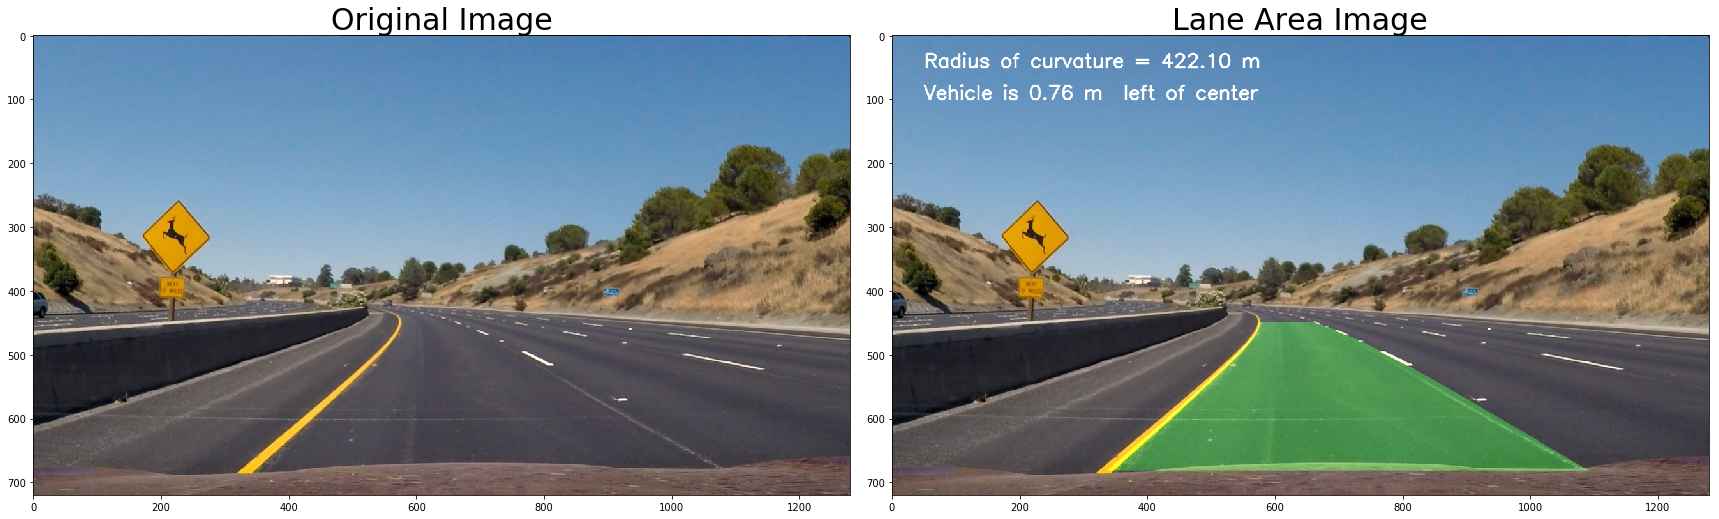

In [16]:
#Subplot Initialization for pileline demo
f,(ax1,ax2) = plt.subplots(1,2,figsize = (24,9))
f.tight_layout()
#Plotting all the original and undstorted images on subplot
ax1.imshow(rd_img,cmap='gray')
ax1.set_title('Original Image',fontsize=30)
test_obj = Lanefill()
img_lane_area = test_obj.draw_lane_polynomials(rd_img)
ax2.imshow(img_lane_area,cmap='gray')
ax2.set_title('Lane Area Image',fontsize=30)
#ax2.set_title('Lane Line Polynomials',fontsize=30)

In [17]:
# Video processing code
from moviepy.editor import VideoFileClip
from IPython.display import HTML
pipe_obj = Lanefill()
video_output = './laneVideo.mp4'
clip1 = VideoFileClip("./project_video.mp4")
lane_clip = clip1.fl_image(pipe_obj.draw_lane_polynomials)
%time lane_clip.write_videofile(video_output,audio = False)

367 1007
80
517
[MoviePy] >>>> Building video ./laneVideo.mp4
[MoviePy] Writing video ./laneVideo.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

367 1007
687


  0%|                                                                                 | 1/1261 [00:00<05:46,  3.64it/s]

364 1004
684


  0%|▏                                                                                | 2/1261 [00:00<05:35,  3.75it/s]

365 1005
685


  0%|▏                                                                                | 3/1261 [00:00<05:31,  3.80it/s]

366 1006
686


  0%|▎                                                                                | 4/1261 [00:01<05:29,  3.82it/s]

367 1007
687


  0%|▎                                                                                | 5/1261 [00:01<05:26,  3.85it/s]

369 1009
689


  0%|▍                                                                                | 6/1261 [00:01<05:37,  3.72it/s]

369 1009
689


  1%|▍                                                                                | 7/1261 [00:01<05:31,  3.79it/s]

372 1012
692


  1%|▌                                                                                | 8/1261 [00:02<05:36,  3.72it/s]

372 1012
692


  1%|▌                                                                                | 9/1261 [00:02<05:27,  3.82it/s]

372 1012
692


  1%|▋                                                                               | 10/1261 [00:02<05:23,  3.87it/s]

372 1012
692


  1%|▋                                                                               | 11/1261 [00:02<05:15,  3.96it/s]

369 1009
689


  1%|▊                                                                               | 12/1261 [00:03<05:14,  3.97it/s]

370 1010
690


  1%|▊                                                                               | 13/1261 [00:03<05:14,  3.97it/s]

370 1010
690


  1%|▉                                                                               | 14/1261 [00:03<05:12,  3.99it/s]

370 1010
690


  1%|▉                                                                               | 15/1261 [00:03<05:11,  3.99it/s]

371 1011
691


  1%|█                                                                               | 16/1261 [00:04<05:10,  4.01it/s]

370 1010
690


  1%|█                                                                               | 17/1261 [00:04<05:12,  3.98it/s]

370 1010
690


  1%|█▏                                                                              | 18/1261 [00:04<05:11,  3.99it/s]

370 1010
690


  2%|█▏                                                                              | 19/1261 [00:04<05:12,  3.97it/s]

366 1006
686


  2%|█▎                                                                              | 20/1261 [00:05<05:10,  4.00it/s]

366 1006
686


  2%|█▎                                                                              | 21/1261 [00:05<05:10,  3.99it/s]

348 988
668


  2%|█▍                                                                              | 22/1261 [00:05<05:08,  4.02it/s]

348 988
668


  2%|█▍                                                                              | 23/1261 [00:05<05:11,  3.97it/s]

355 995
675


  2%|█▌                                                                              | 24/1261 [00:06<05:17,  3.89it/s]

356 996
676


  2%|█▌                                                                              | 25/1261 [00:06<05:13,  3.94it/s]

359 999
679


  2%|█▋                                                                              | 26/1261 [00:06<05:14,  3.93it/s]

355 995
675


  2%|█▋                                                                              | 27/1261 [00:06<05:13,  3.93it/s]

349 989
669


  2%|█▊                                                                              | 28/1261 [00:07<05:15,  3.91it/s]

352 992
672


  2%|█▊                                                                              | 29/1261 [00:07<05:17,  3.88it/s]

350 990
670


  2%|█▉                                                                              | 30/1261 [00:07<05:18,  3.87it/s]

355 995
675


  2%|█▉                                                                              | 31/1261 [00:07<05:16,  3.89it/s]

354 994
674


  3%|██                                                                              | 32/1261 [00:08<05:18,  3.86it/s]

353 993
673


  3%|██                                                                              | 33/1261 [00:08<05:17,  3.87it/s]

355 995
675


  3%|██▏                                                                             | 34/1261 [00:08<05:11,  3.94it/s]

355 995
675


  3%|██▏                                                                             | 35/1261 [00:08<05:05,  4.01it/s]

358 998
678


  3%|██▎                                                                             | 36/1261 [00:09<05:04,  4.03it/s]

359 999
679


  3%|██▎                                                                             | 37/1261 [00:09<05:10,  3.94it/s]

361 1001
681


  3%|██▍                                                                             | 38/1261 [00:09<05:12,  3.91it/s]

361 1001
681


  3%|██▍                                                                             | 39/1261 [00:09<05:09,  3.95it/s]

362 1002
682


  3%|██▌                                                                             | 40/1261 [00:10<05:02,  4.03it/s]

362 1002
682


  3%|██▌                                                                             | 41/1261 [00:10<05:02,  4.04it/s]

362 1002
682


  3%|██▋                                                                             | 42/1261 [00:10<04:58,  4.09it/s]

363 1003
683


  3%|██▋                                                                             | 43/1261 [00:10<05:03,  4.02it/s]

363 1003
683


  3%|██▊                                                                             | 44/1261 [00:11<05:12,  3.90it/s]

363 1003
683


  4%|██▊                                                                             | 45/1261 [00:11<05:12,  3.89it/s]

363 1003
683


  4%|██▉                                                                             | 46/1261 [00:11<05:03,  4.00it/s]

362 1002
682


  4%|██▉                                                                             | 47/1261 [00:11<05:06,  3.96it/s]

363 1003
683


  4%|███                                                                             | 48/1261 [00:12<05:07,  3.95it/s]

362 1002
682


  4%|███                                                                             | 49/1261 [00:12<05:08,  3.93it/s]

363 1003
683


  4%|███▏                                                                            | 50/1261 [00:12<05:10,  3.90it/s]

363 1003
683


  4%|███▏                                                                            | 51/1261 [00:12<05:08,  3.92it/s]

364 1004
684


  4%|███▎                                                                            | 52/1261 [00:13<05:11,  3.88it/s]

364 1004
684


  4%|███▎                                                                            | 53/1261 [00:13<05:10,  3.89it/s]

364 1004
684


  4%|███▍                                                                            | 54/1261 [00:13<05:10,  3.89it/s]

364 1004
684


  4%|███▍                                                                            | 55/1261 [00:14<05:15,  3.82it/s]

363 1003
683


  4%|███▌                                                                            | 56/1261 [00:14<05:11,  3.87it/s]

363 1003
683


  5%|███▌                                                                            | 57/1261 [00:14<05:15,  3.82it/s]

361 1001
681


  5%|███▋                                                                            | 58/1261 [00:14<05:14,  3.83it/s]

362 1002
682


  5%|███▋                                                                            | 59/1261 [00:15<05:17,  3.78it/s]

363 1003
683


  5%|███▊                                                                            | 60/1261 [00:15<05:21,  3.74it/s]

346 986
666


  5%|███▊                                                                            | 61/1261 [00:15<05:24,  3.70it/s]

351 991
671


  5%|███▉                                                                            | 62/1261 [00:15<05:56,  3.36it/s]

354 994
674


  5%|███▉                                                                            | 63/1261 [00:16<06:16,  3.18it/s]

358 998
678


  5%|████                                                                            | 64/1261 [00:16<06:57,  2.87it/s]

357 997
677


  5%|████                                                                            | 65/1261 [00:17<06:37,  3.01it/s]

360 1000
680


  5%|████▏                                                                           | 66/1261 [00:17<06:05,  3.27it/s]

354 994
674


  5%|████▎                                                                           | 67/1261 [00:17<05:58,  3.33it/s]

352 992
672


  5%|████▎                                                                           | 68/1261 [00:17<06:12,  3.21it/s]

353 993
673


  5%|████▍                                                                           | 69/1261 [00:18<06:08,  3.23it/s]

350 990
670


  6%|████▍                                                                           | 70/1261 [00:18<06:41,  2.96it/s]

350 990
670


  6%|████▌                                                                           | 71/1261 [00:18<06:24,  3.09it/s]

348 988
668


  6%|████▌                                                                           | 72/1261 [00:19<06:04,  3.26it/s]

348 988
668


  6%|████▋                                                                           | 73/1261 [00:19<05:52,  3.37it/s]

348 988
668


  6%|████▋                                                                           | 74/1261 [00:19<05:47,  3.41it/s]

347 987
667


  6%|████▊                                                                           | 75/1261 [00:20<05:38,  3.50it/s]

347 987
667


  6%|████▊                                                                           | 76/1261 [00:20<05:33,  3.56it/s]

346 986
666


  6%|████▉                                                                           | 77/1261 [00:20<05:29,  3.60it/s]

345 985
665


  6%|████▉                                                                           | 78/1261 [00:20<05:29,  3.59it/s]

344 984
664


  6%|█████                                                                           | 79/1261 [00:21<05:21,  3.68it/s]

344 984
664


  6%|█████                                                                           | 80/1261 [00:21<05:20,  3.68it/s]

332 972
652


  6%|█████▏                                                                          | 81/1261 [00:21<06:00,  3.27it/s]

333 973
653


  7%|█████▏                                                                          | 82/1261 [00:22<05:48,  3.39it/s]

335 975
655


  7%|█████▎                                                                          | 83/1261 [00:22<05:36,  3.51it/s]

315 955
635


  7%|█████▎                                                                          | 84/1261 [00:22<05:38,  3.48it/s]

321 961
641


  7%|█████▍                                                                          | 85/1261 [00:22<05:36,  3.50it/s]

321 961
641


  7%|█████▍                                                                          | 86/1261 [00:23<05:29,  3.56it/s]

330 970
650


  7%|█████▌                                                                          | 87/1261 [00:23<05:22,  3.64it/s]

336 976
656


  7%|█████▌                                                                          | 88/1261 [00:23<05:23,  3.62it/s]

335 975
655


  7%|█████▋                                                                          | 89/1261 [00:23<05:16,  3.71it/s]

337 977
657


  7%|█████▋                                                                          | 90/1261 [00:24<05:18,  3.68it/s]

337 977
657


  7%|█████▊                                                                          | 91/1261 [00:24<05:12,  3.74it/s]

337 977
657


  7%|█████▊                                                                          | 92/1261 [00:24<05:08,  3.79it/s]

339 979
659


  7%|█████▉                                                                          | 93/1261 [00:24<05:04,  3.84it/s]

340 980
660


  7%|█████▉                                                                          | 94/1261 [00:25<05:05,  3.82it/s]

339 979
659


  8%|██████                                                                          | 95/1261 [00:25<05:01,  3.86it/s]

339 979
659


  8%|██████                                                                          | 96/1261 [00:25<05:01,  3.87it/s]

340 980
660


  8%|██████▏                                                                         | 97/1261 [00:25<04:58,  3.90it/s]

339 979
659


  8%|██████▏                                                                         | 98/1261 [00:26<04:57,  3.91it/s]

341 981
661


  8%|██████▎                                                                         | 99/1261 [00:26<04:57,  3.90it/s]

341 981
661


  8%|██████▎                                                                        | 100/1261 [00:26<04:50,  3.99it/s]

343 983
663


  8%|██████▎                                                                        | 101/1261 [00:27<04:53,  3.96it/s]

344 984
664


  8%|██████▍                                                                        | 102/1261 [00:27<04:54,  3.94it/s]

345 985
665


  8%|██████▍                                                                        | 103/1261 [00:27<04:53,  3.95it/s]

346 986
666


  8%|██████▌                                                                        | 104/1261 [00:27<04:53,  3.95it/s]

346 986
666


  8%|██████▌                                                                        | 105/1261 [00:28<05:01,  3.83it/s]

346 986
666


  8%|██████▋                                                                        | 106/1261 [00:28<05:02,  3.82it/s]

346 986
666


  8%|██████▋                                                                        | 107/1261 [00:28<05:04,  3.79it/s]

349 989
669


  9%|██████▊                                                                        | 108/1261 [00:28<04:59,  3.85it/s]

349 989
669


  9%|██████▊                                                                        | 109/1261 [00:29<04:57,  3.87it/s]

348 988
668


  9%|██████▉                                                                        | 110/1261 [00:29<04:57,  3.87it/s]

349 989
669


  9%|██████▉                                                                        | 111/1261 [00:29<04:53,  3.92it/s]

348 988
668


  9%|███████                                                                        | 112/1261 [00:29<04:53,  3.92it/s]

350 990
670


  9%|███████                                                                        | 113/1261 [00:30<04:50,  3.95it/s]

351 991
671


  9%|███████▏                                                                       | 114/1261 [00:30<04:47,  3.99it/s]

353 993
673


  9%|███████▏                                                                       | 115/1261 [00:30<04:50,  3.95it/s]

353 993
673


  9%|███████▎                                                                       | 116/1261 [00:30<04:49,  3.95it/s]

353 993
673


  9%|███████▎                                                                       | 117/1261 [00:31<04:52,  3.91it/s]

354 994
674


  9%|███████▍                                                                       | 118/1261 [00:31<05:01,  3.79it/s]

355 995
675


  9%|███████▍                                                                       | 119/1261 [00:31<04:57,  3.84it/s]

357 997
677


 10%|███████▌                                                                       | 120/1261 [00:31<04:53,  3.88it/s]

357 997
677


 10%|███████▌                                                                       | 121/1261 [00:32<04:52,  3.90it/s]

359 999
679


 10%|███████▋                                                                       | 122/1261 [00:32<04:51,  3.91it/s]

360 1000
680


 10%|███████▋                                                                       | 123/1261 [00:32<04:48,  3.94it/s]

362 1002
682


 10%|███████▊                                                                       | 124/1261 [00:32<04:46,  3.97it/s]

362 1002
682


 10%|███████▊                                                                       | 125/1261 [00:33<04:45,  3.98it/s]

362 1002
682


 10%|███████▉                                                                       | 126/1261 [00:33<04:46,  3.95it/s]

363 1003
683


 10%|███████▉                                                                       | 127/1261 [00:33<04:48,  3.94it/s]

363 1003
683


 10%|████████                                                                       | 128/1261 [00:33<04:48,  3.93it/s]

365 1005
685


 10%|████████                                                                       | 129/1261 [00:34<04:46,  3.95it/s]

365 1005
685


 10%|████████▏                                                                      | 130/1261 [00:34<04:43,  3.99it/s]

366 1006
686


 10%|████████▏                                                                      | 131/1261 [00:34<04:46,  3.95it/s]

367 1007
687


 10%|████████▎                                                                      | 132/1261 [00:34<04:47,  3.93it/s]

367 1007
687


 11%|████████▎                                                                      | 133/1261 [00:35<04:46,  3.94it/s]

369 1009
689


 11%|████████▍                                                                      | 134/1261 [00:35<04:44,  3.96it/s]

370 1010
690


 11%|████████▍                                                                      | 135/1261 [00:35<04:44,  3.96it/s]

371 1011
691


 11%|████████▌                                                                      | 136/1261 [00:35<04:43,  3.97it/s]

371 1011
691


 11%|████████▌                                                                      | 137/1261 [00:36<04:45,  3.93it/s]

368 1008
688


 11%|████████▋                                                                      | 138/1261 [00:36<04:48,  3.89it/s]

368 1008
688


 11%|████████▋                                                                      | 139/1261 [00:36<04:48,  3.89it/s]

367 1007
687


 11%|████████▊                                                                      | 140/1261 [00:36<04:46,  3.91it/s]

367 1007
687


 11%|████████▊                                                                      | 141/1261 [00:37<04:42,  3.97it/s]

367 1007
687


 11%|████████▉                                                                      | 142/1261 [00:37<04:40,  3.98it/s]

367 1007
687


 11%|████████▉                                                                      | 143/1261 [00:37<04:37,  4.03it/s]

366 1006
686


 11%|█████████                                                                      | 144/1261 [00:37<04:41,  3.97it/s]

366 1006
686


 11%|█████████                                                                      | 145/1261 [00:38<04:36,  4.04it/s]

365 1005
685


 12%|█████████▏                                                                     | 146/1261 [00:38<04:38,  4.00it/s]

365 1005
685


 12%|█████████▏                                                                     | 147/1261 [00:38<04:37,  4.01it/s]

366 1006
686


 12%|█████████▎                                                                     | 148/1261 [00:38<04:38,  4.00it/s]

366 1006
686


 12%|█████████▎                                                                     | 149/1261 [00:39<04:38,  4.00it/s]

367 1007
687


 12%|█████████▍                                                                     | 150/1261 [00:39<04:39,  3.98it/s]

366 1006
686


 12%|█████████▍                                                                     | 151/1261 [00:39<04:40,  3.95it/s]

365 1005
685


 12%|█████████▌                                                                     | 152/1261 [00:39<04:44,  3.90it/s]

363 1003
683


 12%|█████████▌                                                                     | 153/1261 [00:40<04:43,  3.91it/s]

362 1002
682


 12%|█████████▋                                                                     | 154/1261 [00:40<04:44,  3.88it/s]

362 1002
682


 12%|█████████▋                                                                     | 155/1261 [00:40<04:42,  3.92it/s]

362 1002
682


 12%|█████████▊                                                                     | 156/1261 [00:40<04:41,  3.92it/s]

361 1001
681


 12%|█████████▊                                                                     | 157/1261 [00:41<04:41,  3.92it/s]

362 1002
682


 13%|█████████▉                                                                     | 158/1261 [00:41<04:41,  3.92it/s]

357 997
677


 13%|█████████▉                                                                     | 159/1261 [00:41<04:41,  3.92it/s]

354 994
674


 13%|██████████                                                                     | 160/1261 [00:42<04:40,  3.92it/s]

353 993
673


 13%|██████████                                                                     | 161/1261 [00:42<04:39,  3.94it/s]

353 993
673


 13%|██████████▏                                                                    | 162/1261 [00:42<04:37,  3.96it/s]

352 992
672


 13%|██████████▏                                                                    | 163/1261 [00:42<04:36,  3.98it/s]

352 992
672


 13%|██████████▎                                                                    | 164/1261 [00:43<04:37,  3.96it/s]

353 993
673


 13%|██████████▎                                                                    | 165/1261 [00:43<04:39,  3.92it/s]

354 994
674


 13%|██████████▍                                                                    | 166/1261 [00:43<04:37,  3.95it/s]

354 994
674


 13%|██████████▍                                                                    | 167/1261 [00:43<04:37,  3.94it/s]

353 993
673


 13%|██████████▌                                                                    | 168/1261 [00:44<04:40,  3.89it/s]

352 992
672


 13%|██████████▌                                                                    | 169/1261 [00:44<04:40,  3.90it/s]

349 989
669


 13%|██████████▋                                                                    | 170/1261 [00:44<04:38,  3.91it/s]

349 989
669


 14%|██████████▋                                                                    | 171/1261 [00:44<04:34,  3.97it/s]

348 988
668


 14%|██████████▊                                                                    | 172/1261 [00:45<04:33,  3.98it/s]

347 987
667


 14%|██████████▊                                                                    | 173/1261 [00:45<04:34,  3.97it/s]

348 988
668


 14%|██████████▉                                                                    | 174/1261 [00:45<04:31,  4.00it/s]

348 988
668


 14%|██████████▉                                                                    | 175/1261 [00:45<04:32,  3.99it/s]

347 987
667


 14%|███████████                                                                    | 176/1261 [00:46<04:30,  4.01it/s]

345 985
665


 14%|███████████                                                                    | 177/1261 [00:46<04:29,  4.03it/s]

344 984
664


 14%|███████████▏                                                                   | 178/1261 [00:46<05:02,  3.58it/s]

345 985
665


 14%|███████████▏                                                                   | 179/1261 [00:46<05:00,  3.60it/s]

337 977
657


 14%|███████████▎                                                                   | 180/1261 [00:47<04:57,  3.64it/s]

342 982
662


 14%|███████████▎                                                                   | 181/1261 [00:47<04:50,  3.71it/s]

343 983
663


 14%|███████████▍                                                                   | 182/1261 [00:47<04:45,  3.78it/s]

343 983
663


 15%|███████████▍                                                                   | 183/1261 [00:47<04:43,  3.80it/s]

343 983
663


 15%|███████████▌                                                                   | 184/1261 [00:48<04:44,  3.78it/s]

344 984
664


 15%|███████████▌                                                                   | 185/1261 [00:48<05:04,  3.54it/s]

345 985
665


 15%|███████████▋                                                                   | 186/1261 [00:48<04:59,  3.59it/s]

344 984
664


 15%|███████████▋                                                                   | 187/1261 [00:49<04:53,  3.66it/s]

346 986
666


 15%|███████████▊                                                                   | 188/1261 [00:49<04:51,  3.68it/s]

347 987
667


 15%|███████████▊                                                                   | 189/1261 [00:49<04:51,  3.68it/s]

350 990
670


 15%|███████████▉                                                                   | 190/1261 [00:49<04:50,  3.69it/s]

354 994
674


 15%|███████████▉                                                                   | 191/1261 [00:50<04:45,  3.75it/s]

355 995
675


 15%|████████████                                                                   | 192/1261 [00:50<04:45,  3.74it/s]

358 998
678


 15%|████████████                                                                   | 193/1261 [00:50<04:46,  3.72it/s]

359 999
679


 15%|████████████▏                                                                  | 194/1261 [00:50<04:44,  3.75it/s]

360 1000
680


 15%|████████████▏                                                                  | 195/1261 [00:51<04:44,  3.74it/s]

358 998
678


 16%|████████████▎                                                                  | 196/1261 [00:51<04:41,  3.79it/s]

355 995
675


 16%|████████████▎                                                                  | 197/1261 [00:51<04:39,  3.81it/s]

352 992
672


 16%|████████████▍                                                                  | 198/1261 [00:51<04:36,  3.85it/s]

348 988
668


 16%|████████████▍                                                                  | 199/1261 [00:52<04:34,  3.86it/s]

348 988
668


 16%|████████████▌                                                                  | 200/1261 [00:52<04:39,  3.80it/s]

346 986
666


 16%|████████████▌                                                                  | 201/1261 [00:52<04:42,  3.75it/s]

345 985
665


 16%|████████████▋                                                                  | 202/1261 [00:53<04:44,  3.72it/s]

345 985
665


 16%|████████████▋                                                                  | 203/1261 [00:53<04:41,  3.76it/s]

343 983
663


 16%|████████████▊                                                                  | 204/1261 [00:53<04:42,  3.75it/s]

344 984
664


 16%|████████████▊                                                                  | 205/1261 [00:53<04:40,  3.76it/s]

345 985
665


 16%|████████████▉                                                                  | 206/1261 [00:54<04:41,  3.74it/s]

347 987
667


 16%|████████████▉                                                                  | 207/1261 [00:54<04:37,  3.80it/s]

348 988
668


 16%|█████████████                                                                  | 208/1261 [00:54<04:43,  3.71it/s]

348 988
668


 17%|█████████████                                                                  | 209/1261 [00:54<04:40,  3.74it/s]

348 988
668


 17%|█████████████▏                                                                 | 210/1261 [00:55<04:38,  3.78it/s]

347 987
667


 17%|█████████████▏                                                                 | 211/1261 [00:55<04:35,  3.81it/s]

348 988
668


 17%|█████████████▎                                                                 | 212/1261 [00:55<04:35,  3.81it/s]

347 987
667


 17%|█████████████▎                                                                 | 213/1261 [00:55<04:35,  3.80it/s]

346 986
666


 17%|█████████████▍                                                                 | 214/1261 [00:56<04:40,  3.74it/s]

345 985
665


 17%|█████████████▍                                                                 | 215/1261 [00:56<04:36,  3.79it/s]

345 985
665


 17%|█████████████▌                                                                 | 216/1261 [00:56<04:30,  3.86it/s]

343 983
663


 17%|█████████████▌                                                                 | 217/1261 [00:57<04:30,  3.86it/s]

341 981
661


 17%|█████████████▋                                                                 | 218/1261 [00:57<04:28,  3.89it/s]

341 981
661


 17%|█████████████▋                                                                 | 219/1261 [00:57<04:29,  3.86it/s]

340 980
660


 17%|█████████████▊                                                                 | 220/1261 [00:57<04:30,  3.85it/s]

342 982
662


 18%|█████████████▊                                                                 | 221/1261 [00:58<04:31,  3.83it/s]

342 982
662


 18%|█████████████▉                                                                 | 222/1261 [00:58<04:29,  3.86it/s]

343 983
663


 18%|█████████████▉                                                                 | 223/1261 [00:58<04:30,  3.84it/s]

345 985
665


 18%|██████████████                                                                 | 224/1261 [00:58<04:30,  3.84it/s]

343 983
663


 18%|██████████████                                                                 | 225/1261 [00:59<04:29,  3.85it/s]

341 981
661


 18%|██████████████▏                                                                | 226/1261 [00:59<04:27,  3.87it/s]

342 982
662


 18%|██████████████▏                                                                | 227/1261 [00:59<04:28,  3.85it/s]

341 981
661


 18%|██████████████▎                                                                | 228/1261 [00:59<04:27,  3.86it/s]

340 980
660


 18%|██████████████▎                                                                | 229/1261 [01:00<04:29,  3.83it/s]

338 978
658


 18%|██████████████▍                                                                | 230/1261 [01:00<04:27,  3.86it/s]

337 977
657


 18%|██████████████▍                                                                | 231/1261 [01:00<04:28,  3.84it/s]

335 975
655


 18%|██████████████▌                                                                | 232/1261 [01:00<04:29,  3.82it/s]

333 973
653


 18%|██████████████▌                                                                | 233/1261 [01:01<04:31,  3.79it/s]

331 971
651


 19%|██████████████▋                                                                | 234/1261 [01:01<04:30,  3.80it/s]

331 971
651


 19%|██████████████▋                                                                | 235/1261 [01:01<04:33,  3.75it/s]

331 971
651


 19%|██████████████▊                                                                | 236/1261 [01:02<04:37,  3.70it/s]

327 967
647


 19%|██████████████▊                                                                | 237/1261 [01:02<04:34,  3.73it/s]

329 969
649


 19%|██████████████▉                                                                | 238/1261 [01:02<04:36,  3.70it/s]

328 968
648


 19%|██████████████▉                                                                | 239/1261 [01:02<04:34,  3.72it/s]

326 966
646


 19%|███████████████                                                                | 240/1261 [01:03<04:37,  3.68it/s]

327 967
647


 19%|███████████████                                                                | 241/1261 [01:03<04:34,  3.71it/s]

319 959
639


 19%|███████████████▏                                                               | 242/1261 [01:03<04:33,  3.73it/s]

324 964
644


 19%|███████████████▏                                                               | 243/1261 [01:03<04:31,  3.75it/s]

323 963
643


 19%|███████████████▎                                                               | 244/1261 [01:04<04:49,  3.52it/s]

323 963
643


 19%|███████████████▎                                                               | 245/1261 [01:04<04:46,  3.54it/s]

323 963
643


 20%|███████████████▍                                                               | 246/1261 [01:04<04:55,  3.44it/s]

321 961
641


 20%|███████████████▍                                                               | 247/1261 [01:05<04:51,  3.48it/s]

322 962
642


 20%|███████████████▌                                                               | 248/1261 [01:05<04:45,  3.55it/s]

321 961
641


 20%|███████████████▌                                                               | 249/1261 [01:05<04:42,  3.58it/s]

321 961
641


 20%|███████████████▋                                                               | 250/1261 [01:05<04:40,  3.61it/s]

319 959
639


 20%|███████████████▋                                                               | 251/1261 [01:06<04:43,  3.56it/s]

319 959
639


 20%|███████████████▊                                                               | 252/1261 [01:06<04:36,  3.65it/s]

320 960
640


 20%|███████████████▊                                                               | 253/1261 [01:06<04:33,  3.68it/s]

320 960
640


 20%|███████████████▉                                                               | 254/1261 [01:06<04:29,  3.74it/s]

321 961
641


 20%|███████████████▉                                                               | 255/1261 [01:07<04:31,  3.71it/s]

321 961
641


 20%|████████████████                                                               | 256/1261 [01:07<05:06,  3.28it/s]

322 962
642


 20%|████████████████                                                               | 257/1261 [01:07<04:58,  3.37it/s]

321 961
641


 20%|████████████████▏                                                              | 258/1261 [01:08<04:56,  3.38it/s]

321 961
641


 21%|████████████████▏                                                              | 259/1261 [01:08<04:59,  3.35it/s]

323 963
643


 21%|████████████████▎                                                              | 260/1261 [01:08<04:48,  3.47it/s]

322 962
642


 21%|████████████████▎                                                              | 261/1261 [01:09<04:36,  3.62it/s]

324 964
644


 21%|████████████████▍                                                              | 262/1261 [01:09<04:28,  3.72it/s]

325 965
645


 21%|████████████████▍                                                              | 263/1261 [01:09<04:23,  3.79it/s]

325 965
645


 21%|████████████████▌                                                              | 264/1261 [01:09<04:28,  3.71it/s]

323 963
643


 21%|████████████████▌                                                              | 265/1261 [01:10<04:22,  3.80it/s]

323 963
643


 21%|████████████████▋                                                              | 266/1261 [01:10<04:18,  3.85it/s]

324 964
644


 21%|████████████████▋                                                              | 267/1261 [01:10<04:16,  3.87it/s]

323 963
643


 21%|████████████████▊                                                              | 268/1261 [01:10<04:14,  3.90it/s]

321 961
641


 21%|████████████████▊                                                              | 269/1261 [01:11<04:13,  3.91it/s]

321 961
641


 21%|████████████████▉                                                              | 270/1261 [01:11<04:14,  3.90it/s]

322 962
642


 21%|████████████████▉                                                              | 271/1261 [01:11<04:17,  3.84it/s]

324 964
644


 22%|█████████████████                                                              | 272/1261 [01:11<04:28,  3.68it/s]

325 965
645


 22%|█████████████████                                                              | 273/1261 [01:12<04:47,  3.43it/s]

328 968
648


 22%|█████████████████▏                                                             | 274/1261 [01:12<04:54,  3.36it/s]

329 969
649


 22%|█████████████████▏                                                             | 275/1261 [01:12<04:58,  3.30it/s]

328 968
648


 22%|█████████████████▎                                                             | 276/1261 [01:13<04:54,  3.35it/s]

329 969
649


 22%|█████████████████▎                                                             | 277/1261 [01:13<05:02,  3.25it/s]

329 969
649


 22%|█████████████████▍                                                             | 278/1261 [01:13<04:56,  3.32it/s]

331 971
651


 22%|█████████████████▍                                                             | 279/1261 [01:14<04:52,  3.35it/s]

331 971
651


 22%|█████████████████▌                                                             | 280/1261 [01:14<04:50,  3.38it/s]

332 972
652


 22%|█████████████████▌                                                             | 281/1261 [01:14<04:50,  3.37it/s]

334 974
654


 22%|█████████████████▋                                                             | 282/1261 [01:14<04:48,  3.39it/s]

335 975
655


 22%|█████████████████▋                                                             | 283/1261 [01:15<04:51,  3.36it/s]

336 976
656


 23%|█████████████████▊                                                             | 284/1261 [01:15<04:46,  3.41it/s]

337 977
657


 23%|█████████████████▊                                                             | 285/1261 [01:15<04:44,  3.43it/s]

337 977
657


 23%|█████████████████▉                                                             | 286/1261 [01:16<04:41,  3.46it/s]

338 978
658


 23%|█████████████████▉                                                             | 287/1261 [01:16<04:42,  3.45it/s]

337 977
657


 23%|██████████████████                                                             | 288/1261 [01:16<04:39,  3.48it/s]

341 981
661


 23%|██████████████████                                                             | 289/1261 [01:16<04:41,  3.45it/s]

340 980
660


 23%|██████████████████▏                                                            | 290/1261 [01:17<04:28,  3.62it/s]

342 982
662


 23%|██████████████████▏                                                            | 291/1261 [01:17<04:20,  3.73it/s]

344 984
664


 23%|██████████████████▎                                                            | 292/1261 [01:17<04:12,  3.84it/s]

344 984
664


 23%|██████████████████▎                                                            | 293/1261 [01:17<04:10,  3.86it/s]

346 986
666


 23%|██████████████████▍                                                            | 294/1261 [01:18<04:07,  3.91it/s]

346 986
666


 23%|██████████████████▍                                                            | 295/1261 [01:18<04:06,  3.91it/s]

346 986
666


 23%|██████████████████▌                                                            | 296/1261 [01:18<04:04,  3.95it/s]

346 986
666


 24%|██████████████████▌                                                            | 297/1261 [01:18<04:01,  3.99it/s]

346 986
666


 24%|██████████████████▋                                                            | 298/1261 [01:19<04:01,  3.98it/s]

346 986
666


 24%|██████████████████▋                                                            | 299/1261 [01:19<03:59,  4.02it/s]

345 985
665


 24%|██████████████████▊                                                            | 300/1261 [01:19<03:59,  4.02it/s]

345 985
665


 24%|██████████████████▊                                                            | 301/1261 [01:19<03:56,  4.05it/s]

344 984
664


 24%|██████████████████▉                                                            | 302/1261 [01:20<04:00,  3.99it/s]

343 983
663


 24%|██████████████████▉                                                            | 303/1261 [01:20<03:57,  4.03it/s]

343 983
663


 24%|███████████████████                                                            | 304/1261 [01:20<04:00,  3.98it/s]

342 982
662


 24%|███████████████████                                                            | 305/1261 [01:20<03:59,  3.99it/s]

343 983
663


 24%|███████████████████▏                                                           | 306/1261 [01:21<03:57,  4.01it/s]

343 983
663


 24%|███████████████████▏                                                           | 307/1261 [01:21<04:00,  3.97it/s]

346 986
666


 24%|███████████████████▎                                                           | 308/1261 [01:21<04:00,  3.96it/s]

346 986
666


 25%|███████████████████▎                                                           | 309/1261 [01:21<04:00,  3.96it/s]

347 987
667


 25%|███████████████████▍                                                           | 310/1261 [01:22<03:58,  3.99it/s]

349 989
669


 25%|███████████████████▍                                                           | 311/1261 [01:22<03:59,  3.97it/s]

351 991
671


 25%|███████████████████▌                                                           | 312/1261 [01:22<04:03,  3.90it/s]

353 993
673


 25%|███████████████████▌                                                           | 313/1261 [01:22<04:00,  3.94it/s]

352 992
672


 25%|███████████████████▋                                                           | 314/1261 [01:23<03:59,  3.95it/s]

353 993
673


 25%|███████████████████▋                                                           | 315/1261 [01:23<04:00,  3.94it/s]

352 992
672


 25%|███████████████████▊                                                           | 316/1261 [01:23<04:01,  3.92it/s]

352 992
672


 25%|███████████████████▊                                                           | 317/1261 [01:24<04:10,  3.76it/s]

354 994
674


 25%|███████████████████▉                                                           | 318/1261 [01:24<04:12,  3.74it/s]

354 994
674


 25%|███████████████████▉                                                           | 319/1261 [01:24<04:09,  3.78it/s]

356 996
676


 25%|████████████████████                                                           | 320/1261 [01:24<04:06,  3.82it/s]

356 996
676


 25%|████████████████████                                                           | 321/1261 [01:25<04:10,  3.76it/s]

356 996
676


 26%|████████████████████▏                                                          | 322/1261 [01:25<04:04,  3.83it/s]

356 996
676


 26%|████████████████████▏                                                          | 323/1261 [01:25<04:02,  3.86it/s]

354 994
674


 26%|████████████████████▎                                                          | 324/1261 [01:25<04:00,  3.90it/s]

355 995
675


 26%|████████████████████▎                                                          | 325/1261 [01:26<04:08,  3.77it/s]

355 995
675


 26%|████████████████████▍                                                          | 326/1261 [01:26<04:16,  3.64it/s]

354 994
674


 26%|████████████████████▍                                                          | 327/1261 [01:26<04:18,  3.61it/s]

352 992
672


 26%|████████████████████▌                                                          | 328/1261 [01:26<04:17,  3.62it/s]

350 990
670


 26%|████████████████████▌                                                          | 329/1261 [01:27<04:18,  3.60it/s]

351 991
671


 26%|████████████████████▋                                                          | 330/1261 [01:27<04:21,  3.57it/s]

351 991
671


 26%|████████████████████▋                                                          | 331/1261 [01:27<04:23,  3.53it/s]

355 995
675


 26%|████████████████████▊                                                          | 332/1261 [01:28<04:26,  3.49it/s]

360 1000
680


 26%|████████████████████▊                                                          | 333/1261 [01:28<04:27,  3.47it/s]

359 999
679


 26%|████████████████████▉                                                          | 334/1261 [01:28<04:35,  3.37it/s]

360 1000
680


 27%|████████████████████▉                                                          | 335/1261 [01:29<04:31,  3.41it/s]

352 992
672


 27%|█████████████████████                                                          | 336/1261 [01:29<04:32,  3.40it/s]

352 992
672


 27%|█████████████████████                                                          | 337/1261 [01:29<04:27,  3.46it/s]

353 993
673


 27%|█████████████████████▏                                                         | 338/1261 [01:29<04:28,  3.43it/s]

353 993
673


 27%|█████████████████████▏                                                         | 339/1261 [01:30<04:26,  3.46it/s]

357 997
677


 27%|█████████████████████▎                                                         | 340/1261 [01:30<04:25,  3.47it/s]

357 997
677


 27%|█████████████████████▎                                                         | 341/1261 [01:30<04:25,  3.47it/s]

362 1002
682


 27%|█████████████████████▍                                                         | 342/1261 [01:31<04:25,  3.46it/s]

359 999
679


 27%|█████████████████████▍                                                         | 343/1261 [01:31<04:54,  3.12it/s]

356 996
676


 27%|█████████████████████▌                                                         | 344/1261 [01:31<04:46,  3.20it/s]

356 996
676


 27%|█████████████████████▌                                                         | 345/1261 [01:31<04:35,  3.32it/s]

354 994
674


 27%|█████████████████████▋                                                         | 346/1261 [01:32<04:24,  3.46it/s]

356 996
676


 28%|█████████████████████▋                                                         | 347/1261 [01:32<04:25,  3.45it/s]

355 995
675


 28%|█████████████████████▊                                                         | 348/1261 [01:32<04:23,  3.46it/s]

355 995
675


 28%|█████████████████████▊                                                         | 349/1261 [01:33<04:15,  3.57it/s]

355 995
675


 28%|█████████████████████▉                                                         | 350/1261 [01:33<04:11,  3.63it/s]

355 995
675


 28%|█████████████████████▉                                                         | 351/1261 [01:33<04:07,  3.68it/s]

354 994
674


 28%|██████████████████████                                                         | 352/1261 [01:33<04:06,  3.68it/s]

352 992
672


 28%|██████████████████████                                                         | 353/1261 [01:34<04:03,  3.73it/s]

353 993
673


 28%|██████████████████████▏                                                        | 354/1261 [01:34<04:01,  3.76it/s]

352 992
672


 28%|██████████████████████▏                                                        | 355/1261 [01:34<03:56,  3.83it/s]

353 993
673


 28%|██████████████████████▎                                                        | 356/1261 [01:34<03:55,  3.85it/s]

357 997
677


 28%|██████████████████████▎                                                        | 357/1261 [01:35<03:53,  3.88it/s]

356 996
676


 28%|██████████████████████▍                                                        | 358/1261 [01:35<03:52,  3.89it/s]

359 999
679


 28%|██████████████████████▍                                                        | 359/1261 [01:35<03:49,  3.93it/s]

359 999
679


 29%|██████████████████████▌                                                        | 360/1261 [01:35<03:50,  3.90it/s]

359 999
679


 29%|██████████████████████▌                                                        | 361/1261 [01:36<03:50,  3.90it/s]

361 1001
681


 29%|██████████████████████▋                                                        | 362/1261 [01:36<03:50,  3.90it/s]

360 1000
680


 29%|██████████████████████▋                                                        | 363/1261 [01:36<03:48,  3.92it/s]

363 1003
683


 29%|██████████████████████▊                                                        | 364/1261 [01:36<03:47,  3.94it/s]

362 1002
682


 29%|██████████████████████▊                                                        | 365/1261 [01:37<03:48,  3.93it/s]

362 1002
682


 29%|██████████████████████▉                                                        | 366/1261 [01:37<03:48,  3.92it/s]

361 1001
681


 29%|██████████████████████▉                                                        | 367/1261 [01:37<03:47,  3.93it/s]

360 1000
680


 29%|███████████████████████                                                        | 368/1261 [01:37<03:46,  3.93it/s]

361 1001
681


 29%|███████████████████████                                                        | 369/1261 [01:38<03:46,  3.94it/s]

359 999
679


 29%|███████████████████████▏                                                       | 370/1261 [01:38<03:45,  3.94it/s]

359 999
679


 29%|███████████████████████▏                                                       | 371/1261 [01:38<03:43,  3.98it/s]

356 996
676


 30%|███████████████████████▎                                                       | 372/1261 [01:38<03:43,  3.97it/s]

355 995
675


 30%|███████████████████████▎                                                       | 373/1261 [01:39<03:44,  3.96it/s]

359 999
679


 30%|███████████████████████▍                                                       | 374/1261 [01:39<03:44,  3.95it/s]

360 1000
680


 30%|███████████████████████▍                                                       | 375/1261 [01:39<03:41,  4.00it/s]

367 1007
687


 30%|███████████████████████▌                                                       | 376/1261 [01:39<03:42,  3.98it/s]

367 1007
687


 30%|███████████████████████▌                                                       | 377/1261 [01:40<03:42,  3.98it/s]

369 1009
689


 30%|███████████████████████▋                                                       | 378/1261 [01:40<03:42,  3.97it/s]

366 1006
686


 30%|███████████████████████▋                                                       | 379/1261 [01:40<03:42,  3.97it/s]

364 1004
684


 30%|███████████████████████▊                                                       | 380/1261 [01:40<03:40,  4.00it/s]

362 1002
682


 30%|███████████████████████▊                                                       | 381/1261 [01:41<03:44,  3.93it/s]

361 1001
681


 30%|███████████████████████▉                                                       | 382/1261 [01:41<03:41,  3.96it/s]

362 1002
682


 30%|███████████████████████▉                                                       | 383/1261 [01:41<03:43,  3.94it/s]

361 1001
681


 30%|████████████████████████                                                       | 384/1261 [01:42<03:40,  3.97it/s]

360 1000
680


 31%|████████████████████████                                                       | 385/1261 [01:42<03:40,  3.97it/s]

358 998
678


 31%|████████████████████████▏                                                      | 386/1261 [01:42<03:41,  3.94it/s]

354 994
674


 31%|████████████████████████▏                                                      | 387/1261 [01:42<03:40,  3.97it/s]

356 996
676


 31%|████████████████████████▎                                                      | 388/1261 [01:43<03:40,  3.96it/s]

353 993
673


 31%|████████████████████████▎                                                      | 389/1261 [01:43<03:40,  3.96it/s]

351 991
671


 31%|████████████████████████▍                                                      | 390/1261 [01:43<03:41,  3.93it/s]

350 990
670


 31%|████████████████████████▍                                                      | 391/1261 [01:43<03:38,  3.97it/s]

350 990
670


 31%|████████████████████████▌                                                      | 392/1261 [01:44<03:40,  3.93it/s]

351 991
671


 31%|████████████████████████▌                                                      | 393/1261 [01:44<03:40,  3.94it/s]

351 991
671


 31%|████████████████████████▋                                                      | 394/1261 [01:44<03:41,  3.92it/s]

350 990
670


 31%|████████████████████████▋                                                      | 395/1261 [01:44<03:40,  3.93it/s]

349 989
669


 31%|████████████████████████▊                                                      | 396/1261 [01:45<03:41,  3.90it/s]

348 988
668


 31%|████████████████████████▊                                                      | 397/1261 [01:45<03:40,  3.93it/s]

348 988
668


 32%|████████████████████████▉                                                      | 398/1261 [01:45<03:42,  3.87it/s]

345 985
665


 32%|████████████████████████▉                                                      | 399/1261 [01:45<03:42,  3.87it/s]

345 985
665


 32%|█████████████████████████                                                      | 400/1261 [01:46<03:39,  3.91it/s]

344 984
664


 32%|█████████████████████████                                                      | 401/1261 [01:46<03:39,  3.91it/s]

343 983
663


 32%|█████████████████████████▏                                                     | 402/1261 [01:46<03:43,  3.84it/s]

343 983
663


 32%|█████████████████████████▏                                                     | 403/1261 [01:46<03:41,  3.87it/s]

342 982
662


 32%|█████████████████████████▎                                                     | 404/1261 [01:47<03:41,  3.87it/s]

342 982
662


 32%|█████████████████████████▎                                                     | 405/1261 [01:47<03:41,  3.86it/s]

341 981
661


 32%|█████████████████████████▍                                                     | 406/1261 [01:47<03:39,  3.89it/s]

340 980
660


 32%|█████████████████████████▍                                                     | 407/1261 [01:47<03:36,  3.95it/s]

340 980
660


 32%|█████████████████████████▌                                                     | 408/1261 [01:48<03:35,  3.95it/s]

340 980
660


 32%|█████████████████████████▌                                                     | 409/1261 [01:48<03:34,  3.98it/s]

340 980
660


 33%|█████████████████████████▋                                                     | 410/1261 [01:48<04:05,  3.46it/s]

339 979
659


 33%|█████████████████████████▋                                                     | 411/1261 [01:49<03:58,  3.57it/s]

338 978
658


 33%|█████████████████████████▊                                                     | 412/1261 [01:49<03:52,  3.65it/s]

339 979
659


 33%|█████████████████████████▊                                                     | 413/1261 [01:49<03:50,  3.68it/s]

340 980
660


 33%|█████████████████████████▉                                                     | 414/1261 [01:49<03:46,  3.74it/s]

338 978
658


 33%|█████████████████████████▉                                                     | 415/1261 [01:50<03:44,  3.76it/s]

334 974
654


 33%|██████████████████████████                                                     | 416/1261 [01:50<03:41,  3.82it/s]

334 974
654


 33%|██████████████████████████                                                     | 417/1261 [01:50<03:40,  3.83it/s]

333 973
653


 33%|██████████████████████████▏                                                    | 418/1261 [01:50<03:39,  3.84it/s]

332 972
652


 33%|██████████████████████████▏                                                    | 419/1261 [01:51<03:39,  3.83it/s]

333 973
653


 33%|██████████████████████████▎                                                    | 420/1261 [01:51<03:39,  3.83it/s]

333 973
653


 33%|██████████████████████████▍                                                    | 421/1261 [01:51<03:41,  3.80it/s]

334 974
654


 33%|██████████████████████████▍                                                    | 422/1261 [01:51<03:50,  3.63it/s]

332 972
652


 34%|██████████████████████████▌                                                    | 423/1261 [01:52<03:51,  3.63it/s]

331 971
651


 34%|██████████████████████████▌                                                    | 424/1261 [01:52<03:50,  3.63it/s]

331 971
651


 34%|██████████████████████████▋                                                    | 425/1261 [01:52<03:46,  3.68it/s]

329 969
649


 34%|██████████████████████████▋                                                    | 426/1261 [01:53<03:45,  3.71it/s]

329 969
649


 34%|██████████████████████████▊                                                    | 427/1261 [01:53<03:43,  3.73it/s]

328 968
648


 34%|██████████████████████████▊                                                    | 428/1261 [01:53<03:41,  3.76it/s]

328 968
648


 34%|██████████████████████████▉                                                    | 429/1261 [01:53<03:44,  3.71it/s]

327 967
647


 34%|██████████████████████████▉                                                    | 430/1261 [01:54<03:51,  3.58it/s]

326 966
646


 34%|███████████████████████████                                                    | 431/1261 [01:54<03:46,  3.66it/s]

326 966
646


 34%|███████████████████████████                                                    | 432/1261 [01:54<03:42,  3.73it/s]

324 964
644


 34%|███████████████████████████▏                                                   | 433/1261 [01:54<03:41,  3.74it/s]

324 964
644


 34%|███████████████████████████▏                                                   | 434/1261 [01:55<03:43,  3.69it/s]

323 963
643


 34%|███████████████████████████▎                                                   | 435/1261 [01:55<03:45,  3.67it/s]

323 963
643


 35%|███████████████████████████▎                                                   | 436/1261 [01:55<03:39,  3.75it/s]

324 964
644


 35%|███████████████████████████▍                                                   | 437/1261 [01:55<03:36,  3.80it/s]

323 963
643


 35%|███████████████████████████▍                                                   | 438/1261 [01:56<03:39,  3.74it/s]

324 964
644


 35%|███████████████████████████▌                                                   | 439/1261 [01:56<03:35,  3.81it/s]

325 965
645


 35%|███████████████████████████▌                                                   | 440/1261 [01:56<03:34,  3.84it/s]

324 964
644


 35%|███████████████████████████▋                                                   | 441/1261 [01:56<03:31,  3.88it/s]

323 963
643


 35%|███████████████████████████▋                                                   | 442/1261 [01:57<03:28,  3.93it/s]

320 960
640


 35%|███████████████████████████▊                                                   | 443/1261 [01:57<03:28,  3.92it/s]

319 959
639


 35%|███████████████████████████▊                                                   | 444/1261 [01:57<03:28,  3.92it/s]

317 957
637


 35%|███████████████████████████▉                                                   | 445/1261 [01:58<03:28,  3.92it/s]

317 957
637


 35%|███████████████████████████▉                                                   | 446/1261 [01:58<03:29,  3.88it/s]

317 957
637


 35%|████████████████████████████                                                   | 447/1261 [01:58<03:45,  3.61it/s]

316 956
636


 36%|████████████████████████████                                                   | 448/1261 [01:58<03:39,  3.70it/s]

317 957
637


 36%|████████████████████████████▏                                                  | 449/1261 [01:59<03:38,  3.72it/s]

316 956
636


 36%|████████████████████████████▏                                                  | 450/1261 [01:59<03:35,  3.76it/s]

317 957
637


 36%|████████████████████████████▎                                                  | 451/1261 [01:59<03:33,  3.79it/s]

317 957
637


 36%|████████████████████████████▎                                                  | 452/1261 [01:59<03:30,  3.83it/s]

316 956
636


 36%|████████████████████████████▍                                                  | 453/1261 [02:00<03:28,  3.87it/s]

323 963
643


 36%|████████████████████████████▍                                                  | 454/1261 [02:00<03:26,  3.92it/s]

323 963
643


 36%|████████████████████████████▌                                                  | 455/1261 [02:00<03:27,  3.88it/s]

324 964
644


 36%|████████████████████████████▌                                                  | 456/1261 [02:00<03:22,  3.97it/s]

329 969
649


 36%|████████████████████████████▋                                                  | 457/1261 [02:01<03:24,  3.94it/s]

329 969
649


 36%|████████████████████████████▋                                                  | 458/1261 [02:01<03:22,  3.97it/s]

335 975
655


 36%|████████████████████████████▊                                                  | 459/1261 [02:01<03:22,  3.96it/s]

333 973
653


 36%|████████████████████████████▊                                                  | 460/1261 [02:01<03:20,  4.00it/s]

333 973
653


 37%|████████████████████████████▉                                                  | 461/1261 [02:02<03:20,  4.00it/s]

331 971
651


 37%|████████████████████████████▉                                                  | 462/1261 [02:02<03:21,  3.97it/s]

328 968
648


 37%|█████████████████████████████                                                  | 463/1261 [02:02<03:23,  3.92it/s]

333 973
653


 37%|█████████████████████████████                                                  | 464/1261 [02:02<03:22,  3.93it/s]

333 973
653


 37%|█████████████████████████████▏                                                 | 465/1261 [02:03<03:21,  3.95it/s]

335 975
655


 37%|█████████████████████████████▏                                                 | 466/1261 [02:03<03:22,  3.93it/s]

335 975
655


 37%|█████████████████████████████▎                                                 | 467/1261 [02:03<03:23,  3.91it/s]

334 974
654


 37%|█████████████████████████████▎                                                 | 468/1261 [02:03<03:22,  3.91it/s]

333 973
653


 37%|█████████████████████████████▍                                                 | 469/1261 [02:04<03:23,  3.89it/s]

328 968
648


 37%|█████████████████████████████▍                                                 | 470/1261 [02:04<03:23,  3.88it/s]

331 971
651


 37%|█████████████████████████████▌                                                 | 471/1261 [02:04<03:22,  3.90it/s]

330 970
650


 37%|█████████████████████████████▌                                                 | 472/1261 [02:04<03:20,  3.94it/s]

329 969
649


 38%|█████████████████████████████▋                                                 | 473/1261 [02:05<03:19,  3.95it/s]

331 971
651


 38%|█████████████████████████████▋                                                 | 474/1261 [02:05<03:18,  3.97it/s]

327 967
647


 38%|█████████████████████████████▊                                                 | 475/1261 [02:05<03:18,  3.96it/s]

328 968
648


 38%|█████████████████████████████▊                                                 | 476/1261 [02:05<03:19,  3.94it/s]

326 966
646


 38%|█████████████████████████████▉                                                 | 477/1261 [02:06<03:19,  3.93it/s]

325 965
645


 38%|█████████████████████████████▉                                                 | 478/1261 [02:06<03:19,  3.93it/s]

325 965
645


 38%|██████████████████████████████                                                 | 479/1261 [02:06<03:21,  3.88it/s]

324 964
644


 38%|██████████████████████████████                                                 | 480/1261 [02:07<03:31,  3.69it/s]

325 965
645


 38%|██████████████████████████████▏                                                | 481/1261 [02:07<03:31,  3.69it/s]

324 964
644


 38%|██████████████████████████████▏                                                | 482/1261 [02:07<03:28,  3.73it/s]

322 962
642


 38%|██████████████████████████████▎                                                | 483/1261 [02:07<03:30,  3.70it/s]

323 963
643


 38%|██████████████████████████████▎                                                | 484/1261 [02:08<03:29,  3.71it/s]

322 962
642


 38%|██████████████████████████████▍                                                | 485/1261 [02:08<03:30,  3.69it/s]

322 962
642


 39%|██████████████████████████████▍                                                | 486/1261 [02:08<03:24,  3.78it/s]

323 963
643


 39%|██████████████████████████████▌                                                | 487/1261 [02:08<03:22,  3.82it/s]

326 966
646


 39%|██████████████████████████████▌                                                | 488/1261 [02:09<03:20,  3.86it/s]

331 971
651


 39%|██████████████████████████████▋                                                | 489/1261 [02:09<03:21,  3.84it/s]

329 969
649


 39%|██████████████████████████████▋                                                | 490/1261 [02:09<03:22,  3.80it/s]

331 971
651


 39%|██████████████████████████████▊                                                | 491/1261 [02:09<03:19,  3.86it/s]

327 967
647


 39%|██████████████████████████████▊                                                | 492/1261 [02:10<03:17,  3.89it/s]

328 968
648


 39%|██████████████████████████████▉                                                | 493/1261 [02:10<03:16,  3.91it/s]

323 963
643


 39%|██████████████████████████████▉                                                | 494/1261 [02:10<03:13,  3.96it/s]

323 963
643


 39%|███████████████████████████████                                                | 495/1261 [02:10<03:13,  3.97it/s]

323 963
643


 39%|███████████████████████████████                                                | 496/1261 [02:11<03:10,  4.01it/s]

325 965
645


 39%|███████████████████████████████▏                                               | 497/1261 [02:11<03:10,  4.01it/s]

326 966
646


 39%|███████████████████████████████▏                                               | 498/1261 [02:11<03:11,  3.98it/s]

324 964
644


 40%|███████████████████████████████▎                                               | 499/1261 [02:11<03:12,  3.95it/s]

321 961
641


 40%|███████████████████████████████▎                                               | 500/1261 [02:12<03:12,  3.96it/s]

322 962
642


 40%|███████████████████████████████▍                                               | 501/1261 [02:12<03:12,  3.94it/s]

319 959
639


 40%|███████████████████████████████▍                                               | 502/1261 [02:12<03:12,  3.95it/s]

321 961
641


 40%|███████████████████████████████▌                                               | 503/1261 [02:12<03:11,  3.95it/s]

321 961
641


 40%|███████████████████████████████▌                                               | 504/1261 [02:13<03:12,  3.94it/s]

321 961
641


 40%|███████████████████████████████▋                                               | 505/1261 [02:13<03:10,  3.97it/s]

322 962
642


 40%|███████████████████████████████▋                                               | 506/1261 [02:13<03:10,  3.97it/s]

321 961
641


 40%|███████████████████████████████▊                                               | 507/1261 [02:13<03:09,  3.98it/s]

321 961
641


 40%|███████████████████████████████▊                                               | 508/1261 [02:14<03:08,  3.99it/s]

320 960
640


 40%|███████████████████████████████▉                                               | 509/1261 [02:14<03:09,  3.97it/s]

320 960
640


 40%|███████████████████████████████▉                                               | 510/1261 [02:14<03:09,  3.96it/s]

320 960
640


 41%|████████████████████████████████                                               | 511/1261 [02:14<03:09,  3.96it/s]

320 960
640


 41%|████████████████████████████████                                               | 512/1261 [02:15<03:10,  3.92it/s]

322 962
642


 41%|████████████████████████████████▏                                              | 513/1261 [02:15<03:10,  3.93it/s]

321 961
641


 41%|████████████████████████████████▏                                              | 514/1261 [02:15<03:11,  3.91it/s]

322 962
642


 41%|████████████████████████████████▎                                              | 515/1261 [02:15<03:08,  3.96it/s]

322 962
642


 41%|████████████████████████████████▎                                              | 516/1261 [02:16<03:09,  3.93it/s]

321 961
641


 41%|████████████████████████████████▍                                              | 517/1261 [02:16<03:19,  3.73it/s]

321 961
641


 41%|████████████████████████████████▍                                              | 518/1261 [02:16<03:17,  3.75it/s]

321 961
641


 41%|████████████████████████████████▌                                              | 519/1261 [02:17<03:12,  3.86it/s]

322 962
642


 41%|████████████████████████████████▌                                              | 520/1261 [02:17<03:12,  3.86it/s]

323 963
643


 41%|████████████████████████████████▋                                              | 521/1261 [02:17<03:16,  3.77it/s]

324 964
644


 41%|████████████████████████████████▋                                              | 522/1261 [02:17<03:19,  3.71it/s]

324 964
644


 41%|████████████████████████████████▊                                              | 523/1261 [02:18<03:32,  3.48it/s]

325 965
645


 42%|████████████████████████████████▊                                              | 524/1261 [02:18<03:25,  3.58it/s]

329 969
649


 42%|████████████████████████████████▉                                              | 525/1261 [02:18<03:18,  3.70it/s]

322 962
642


 42%|████████████████████████████████▉                                              | 526/1261 [02:18<03:17,  3.73it/s]

321 961
641


 42%|█████████████████████████████████                                              | 527/1261 [02:19<03:29,  3.51it/s]

320 960
640


 42%|█████████████████████████████████                                              | 528/1261 [02:19<04:16,  2.86it/s]

320 960
640


 42%|█████████████████████████████████▏                                             | 529/1261 [02:20<04:13,  2.88it/s]

325 965
645


 42%|█████████████████████████████████▏                                             | 530/1261 [02:20<04:07,  2.95it/s]

328 968
648


 42%|█████████████████████████████████▎                                             | 531/1261 [02:20<03:58,  3.07it/s]

335 975
655


 42%|█████████████████████████████████▎                                             | 532/1261 [02:21<03:56,  3.09it/s]

336 976
656


 42%|█████████████████████████████████▍                                             | 533/1261 [02:21<03:47,  3.21it/s]

336 976
656


 42%|█████████████████████████████████▍                                             | 534/1261 [02:21<03:41,  3.29it/s]

334 974
654


 42%|█████████████████████████████████▌                                             | 535/1261 [02:21<03:37,  3.34it/s]

330 970
650


 43%|█████████████████████████████████▌                                             | 536/1261 [02:22<03:34,  3.38it/s]

331 971
651


 43%|█████████████████████████████████▋                                             | 537/1261 [02:22<03:35,  3.37it/s]

330 970
650


 43%|█████████████████████████████████▋                                             | 538/1261 [02:22<03:31,  3.41it/s]

331 971
651


 43%|█████████████████████████████████▊                                             | 539/1261 [02:23<03:27,  3.47it/s]

347 987
667


 43%|█████████████████████████████████▊                                             | 540/1261 [02:23<03:26,  3.48it/s]

349 989
669


 43%|█████████████████████████████████▉                                             | 541/1261 [02:23<03:25,  3.51it/s]

350 990
670


 43%|█████████████████████████████████▉                                             | 542/1261 [02:23<03:27,  3.46it/s]

350 990
670


 43%|██████████████████████████████████                                             | 543/1261 [02:24<03:27,  3.47it/s]

351 991
671


 43%|██████████████████████████████████                                             | 544/1261 [02:24<03:25,  3.48it/s]

350 990
670


 43%|██████████████████████████████████▏                                            | 545/1261 [02:24<03:23,  3.51it/s]

350 990
670


 43%|██████████████████████████████████▏                                            | 546/1261 [02:25<03:23,  3.51it/s]

349 989
669


 43%|██████████████████████████████████▎                                            | 547/1261 [02:25<03:25,  3.48it/s]

348 988
668


 43%|██████████████████████████████████▎                                            | 548/1261 [02:25<03:23,  3.50it/s]

348 988
668


 44%|██████████████████████████████████▍                                            | 549/1261 [02:25<03:22,  3.52it/s]

330 970
650


 44%|██████████████████████████████████▍                                            | 550/1261 [02:26<03:22,  3.52it/s]

329 969
649


 44%|██████████████████████████████████▌                                            | 551/1261 [02:26<03:20,  3.55it/s]

339 979
659


 44%|██████████████████████████████████▌                                            | 552/1261 [02:26<03:27,  3.42it/s]

336 976
656


 44%|██████████████████████████████████▋                                            | 553/1261 [02:27<03:31,  3.35it/s]

338 978
658


 44%|██████████████████████████████████▋                                            | 554/1261 [02:27<03:21,  3.51it/s]

341 981
661


 44%|██████████████████████████████████▊                                            | 555/1261 [02:27<03:13,  3.65it/s]

337 977
657


 44%|██████████████████████████████████▊                                            | 556/1261 [02:27<03:11,  3.69it/s]

342 982
662


 44%|██████████████████████████████████▉                                            | 557/1261 [02:28<03:11,  3.67it/s]

333 973
653


 44%|██████████████████████████████████▉                                            | 558/1261 [02:28<03:56,  2.97it/s]

323 963
643


 44%|███████████████████████████████████                                            | 559/1261 [02:29<04:00,  2.92it/s]

311 951
631


 44%|███████████████████████████████████                                            | 560/1261 [02:29<03:51,  3.02it/s]

302 942
622


 44%|███████████████████████████████████▏                                           | 561/1261 [02:29<03:55,  2.98it/s]

296 936
616


 45%|███████████████████████████████████▏                                           | 562/1261 [02:29<03:53,  2.99it/s]

311 951
631


 45%|███████████████████████████████████▎                                           | 563/1261 [02:30<03:58,  2.92it/s]

319 959
639


 45%|███████████████████████████████████▎                                           | 564/1261 [02:30<03:50,  3.02it/s]

327 967
647


 45%|███████████████████████████████████▍                                           | 565/1261 [02:30<03:42,  3.12it/s]

337 977
657


 45%|███████████████████████████████████▍                                           | 566/1261 [02:31<03:34,  3.24it/s]

340 980
660


 45%|███████████████████████████████████▌                                           | 567/1261 [02:31<03:26,  3.37it/s]

345 985
665


 45%|███████████████████████████████████▌                                           | 568/1261 [02:31<03:18,  3.48it/s]

341 981
661


 45%|███████████████████████████████████▋                                           | 569/1261 [02:32<03:16,  3.52it/s]

337 977
657


 45%|███████████████████████████████████▋                                           | 570/1261 [02:32<03:14,  3.54it/s]

333 973
653


 45%|███████████████████████████████████▊                                           | 571/1261 [02:32<03:10,  3.63it/s]

333 973
653


 45%|███████████████████████████████████▊                                           | 572/1261 [02:32<03:08,  3.65it/s]

327 967
647


 45%|███████████████████████████████████▉                                           | 573/1261 [02:33<03:06,  3.70it/s]

330 970
650


 46%|███████████████████████████████████▉                                           | 574/1261 [02:33<03:05,  3.71it/s]

335 975
655


 46%|████████████████████████████████████                                           | 575/1261 [02:33<03:05,  3.69it/s]

337 977
657


 46%|████████████████████████████████████                                           | 576/1261 [02:33<03:04,  3.72it/s]

338 978
658


 46%|████████████████████████████████████▏                                          | 577/1261 [02:34<03:01,  3.77it/s]

343 983
663


 46%|████████████████████████████████████▏                                          | 578/1261 [02:34<02:56,  3.87it/s]

344 984
664


 46%|████████████████████████████████████▎                                          | 579/1261 [02:34<02:53,  3.93it/s]

343 983
663


 46%|████████████████████████████████████▎                                          | 580/1261 [02:34<02:50,  3.99it/s]

342 982
662


 46%|████████████████████████████████████▍                                          | 581/1261 [02:35<02:53,  3.93it/s]

341 981
661


 46%|████████████████████████████████████▍                                          | 582/1261 [02:35<02:53,  3.92it/s]

341 981
661


 46%|████████████████████████████████████▌                                          | 583/1261 [02:35<02:50,  3.97it/s]

344 984
664


 46%|████████████████████████████████████▌                                          | 584/1261 [02:35<02:49,  3.99it/s]

338 978
658


 46%|████████████████████████████████████▋                                          | 585/1261 [02:36<02:45,  4.08it/s]

343 983
663


 46%|████████████████████████████████████▋                                          | 586/1261 [02:36<02:47,  4.03it/s]

338 978
658


 47%|████████████████████████████████████▊                                          | 587/1261 [02:36<02:44,  4.09it/s]

338 978
658


 47%|████████████████████████████████████▊                                          | 588/1261 [02:36<03:08,  3.57it/s]

340 980
660


 47%|████████████████████████████████████▉                                          | 589/1261 [02:37<03:47,  2.95it/s]

332 972
652


 47%|████████████████████████████████████▉                                          | 590/1261 [02:37<04:02,  2.77it/s]

326 966
646


 47%|█████████████████████████████████████                                          | 591/1261 [02:38<03:55,  2.84it/s]

327 967
647


 47%|█████████████████████████████████████                                          | 592/1261 [02:38<03:51,  2.89it/s]

324 964
644


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:38<03:46,  2.94it/s]

321 961
641


 47%|█████████████████████████████████████▏                                         | 594/1261 [02:39<03:39,  3.04it/s]

322 962
642


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:39<03:32,  3.13it/s]

320 960
640


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:39<03:28,  3.19it/s]

318 958
638


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:40<03:19,  3.32it/s]

318 958
638


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:40<03:17,  3.36it/s]

316 956
636


 48%|█████████████████████████████████████▌                                         | 599/1261 [02:40<03:15,  3.38it/s]

315 955
635


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:40<03:18,  3.34it/s]

311 951
631


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:41<03:24,  3.23it/s]

309 949
629


 48%|█████████████████████████████████████▋                                         | 602/1261 [02:41<03:24,  3.22it/s]

308 948
628


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:41<03:27,  3.17it/s]

307 947
627


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:42<03:22,  3.25it/s]

310 950
630


 48%|█████████████████████████████████████▉                                         | 605/1261 [02:42<03:20,  3.27it/s]

316 956
636


 48%|█████████████████████████████████████▉                                         | 606/1261 [02:42<03:16,  3.34it/s]

319 959
639


 48%|██████████████████████████████████████                                         | 607/1261 [02:43<03:13,  3.38it/s]

312 952
632


 48%|██████████████████████████████████████                                         | 608/1261 [02:43<03:09,  3.44it/s]

305 945
625


 48%|██████████████████████████████████████▏                                        | 609/1261 [02:43<03:09,  3.44it/s]

302 942
622


 48%|██████████████████████████████████████▏                                        | 610/1261 [02:43<03:09,  3.44it/s]

299 939
619


 48%|██████████████████████████████████████▎                                        | 611/1261 [02:44<03:06,  3.49it/s]

310 950
630


 49%|██████████████████████████████████████▎                                        | 612/1261 [02:44<03:09,  3.42it/s]

310 950
630


 49%|██████████████████████████████████████▍                                        | 613/1261 [02:44<03:13,  3.34it/s]

311 951
631


 49%|██████████████████████████████████████▍                                        | 614/1261 [02:45<03:17,  3.27it/s]

309 949
629


 49%|██████████████████████████████████████▌                                        | 615/1261 [02:45<03:13,  3.34it/s]

310 950
630


 49%|██████████████████████████████████████▌                                        | 616/1261 [02:45<03:09,  3.41it/s]

312 952
632


 49%|██████████████████████████████████████▋                                        | 617/1261 [02:45<03:05,  3.47it/s]

311 951
631


 49%|██████████████████████████████████████▋                                        | 618/1261 [02:46<03:13,  3.32it/s]

314 954
634


 49%|██████████████████████████████████████▊                                        | 619/1261 [02:46<03:19,  3.22it/s]

315 955
635


 49%|██████████████████████████████████████▊                                        | 620/1261 [02:46<03:17,  3.25it/s]

314 954
634


 49%|██████████████████████████████████████▉                                        | 621/1261 [02:47<03:23,  3.15it/s]

313 953
633


 49%|██████████████████████████████████████▉                                        | 622/1261 [02:47<03:20,  3.19it/s]

327 967
647


 49%|███████████████████████████████████████                                        | 623/1261 [02:47<03:23,  3.14it/s]

329 969
649


 49%|███████████████████████████████████████                                        | 624/1261 [02:48<03:24,  3.11it/s]

335 975
655


 50%|███████████████████████████████████████▏                                       | 625/1261 [02:48<03:26,  3.08it/s]

332 972
652


 50%|███████████████████████████████████████▏                                       | 626/1261 [02:48<03:28,  3.05it/s]

334 974
654


 50%|███████████████████████████████████████▎                                       | 627/1261 [02:49<03:31,  3.00it/s]

336 976
656


 50%|███████████████████████████████████████▎                                       | 628/1261 [02:49<03:53,  2.71it/s]

335 975
655


 50%|███████████████████████████████████████▍                                       | 629/1261 [02:50<03:44,  2.82it/s]

331 971
651


 50%|███████████████████████████████████████▍                                       | 630/1261 [02:50<03:57,  2.65it/s]

325 965
645


 50%|███████████████████████████████████████▌                                       | 631/1261 [02:50<03:58,  2.65it/s]

322 962
642


 50%|███████████████████████████████████████▌                                       | 632/1261 [02:51<04:12,  2.49it/s]

320 960
640


 50%|███████████████████████████████████████▋                                       | 633/1261 [02:51<03:55,  2.66it/s]

340 980
660


 50%|███████████████████████████████████████▋                                       | 634/1261 [02:51<03:38,  2.86it/s]

356 996
676


 50%|███████████████████████████████████████▊                                       | 635/1261 [02:52<03:27,  3.02it/s]

336 976
656


 50%|███████████████████████████████████████▊                                       | 636/1261 [02:52<03:22,  3.09it/s]

377 1017
697


 51%|███████████████████████████████████████▉                                       | 637/1261 [02:52<03:15,  3.20it/s]

399 1039
719


 51%|███████████████████████████████████████▉                                       | 638/1261 [02:53<03:07,  3.32it/s]

367 1007
687


 51%|████████████████████████████████████████                                       | 639/1261 [02:53<03:00,  3.44it/s]

358 998
678


 51%|████████████████████████████████████████                                       | 640/1261 [02:53<02:56,  3.53it/s]

376 1016
696


 51%|████████████████████████████████████████▏                                      | 641/1261 [02:53<02:51,  3.62it/s]

350 990
670


 51%|████████████████████████████████████████▏                                      | 642/1261 [02:54<02:49,  3.65it/s]

357 997
677


 51%|████████████████████████████████████████▎                                      | 643/1261 [02:54<02:47,  3.69it/s]

394 1034
714


 51%|████████████████████████████████████████▎                                      | 644/1261 [02:54<02:45,  3.72it/s]

405 1045
725


 51%|████████████████████████████████████████▍                                      | 645/1261 [02:54<02:46,  3.70it/s]

405 1045
725


 51%|████████████████████████████████████████▍                                      | 646/1261 [02:55<02:43,  3.76it/s]

401 1041
721


 51%|████████████████████████████████████████▌                                      | 647/1261 [02:55<02:41,  3.79it/s]

398 1038
718


 51%|████████████████████████████████████████▌                                      | 648/1261 [02:55<02:41,  3.80it/s]

401 1041
721


 51%|████████████████████████████████████████▋                                      | 649/1261 [02:55<02:44,  3.72it/s]

397 1037
717


 52%|████████████████████████████████████████▋                                      | 650/1261 [02:56<02:47,  3.64it/s]

380 1020
700


 52%|████████████████████████████████████████▊                                      | 651/1261 [02:56<02:47,  3.63it/s]

397 1037
717


 52%|████████████████████████████████████████▊                                      | 652/1261 [02:56<02:48,  3.61it/s]

396 1036
716


 52%|████████████████████████████████████████▉                                      | 653/1261 [02:57<02:42,  3.74it/s]

397 1037
717


 52%|████████████████████████████████████████▉                                      | 654/1261 [02:57<02:39,  3.80it/s]

370 1010
690


 52%|█████████████████████████████████████████                                      | 655/1261 [02:57<02:42,  3.72it/s]

376 1016
696


 52%|█████████████████████████████████████████                                      | 656/1261 [02:57<02:55,  3.45it/s]

371 1011
691


 52%|█████████████████████████████████████████▏                                     | 657/1261 [02:58<02:50,  3.54it/s]

372 1012
692


 52%|█████████████████████████████████████████▏                                     | 658/1261 [02:58<02:44,  3.68it/s]

376 1016
696


 52%|█████████████████████████████████████████▎                                     | 659/1261 [02:58<02:48,  3.57it/s]

370 1010
690


 52%|█████████████████████████████████████████▎                                     | 660/1261 [02:59<02:59,  3.35it/s]

372 1012
692


 52%|█████████████████████████████████████████▍                                     | 661/1261 [02:59<02:55,  3.43it/s]

369 1009
689


 52%|█████████████████████████████████████████▍                                     | 662/1261 [02:59<02:46,  3.60it/s]

369 1009
689


 53%|█████████████████████████████████████████▌                                     | 663/1261 [02:59<02:48,  3.54it/s]

368 1008
688


 53%|█████████████████████████████████████████▌                                     | 664/1261 [03:00<02:49,  3.52it/s]

369 1009
689


 53%|█████████████████████████████████████████▋                                     | 665/1261 [03:00<02:45,  3.61it/s]

369 1009
689


 53%|█████████████████████████████████████████▋                                     | 666/1261 [03:00<02:42,  3.66it/s]

370 1010
690


 53%|█████████████████████████████████████████▊                                     | 667/1261 [03:00<02:38,  3.74it/s]

368 1008
688


 53%|█████████████████████████████████████████▊                                     | 668/1261 [03:01<02:33,  3.85it/s]

367 1007
687


 53%|█████████████████████████████████████████▉                                     | 669/1261 [03:01<02:30,  3.94it/s]

366 1006
686


 53%|█████████████████████████████████████████▉                                     | 670/1261 [03:01<02:32,  3.88it/s]

368 1008
688


 53%|██████████████████████████████████████████                                     | 671/1261 [03:01<02:31,  3.89it/s]

367 1007
687


 53%|██████████████████████████████████████████                                     | 672/1261 [03:02<02:27,  3.99it/s]

366 1006
686


 53%|██████████████████████████████████████████▏                                    | 673/1261 [03:02<02:29,  3.93it/s]

367 1007
687


 53%|██████████████████████████████████████████▏                                    | 674/1261 [03:02<02:29,  3.94it/s]

368 1008
688


 54%|██████████████████████████████████████████▎                                    | 675/1261 [03:03<02:30,  3.88it/s]

369 1009
689


 54%|██████████████████████████████████████████▎                                    | 676/1261 [03:03<02:29,  3.92it/s]

404 1044
724


 54%|██████████████████████████████████████████▍                                    | 677/1261 [03:03<02:27,  3.96it/s]

378 1018
698


 54%|██████████████████████████████████████████▍                                    | 678/1261 [03:03<02:26,  3.98it/s]

378 1018
698


 54%|██████████████████████████████████████████▌                                    | 679/1261 [03:04<02:25,  3.99it/s]

401 1041
721


 54%|██████████████████████████████████████████▌                                    | 680/1261 [03:04<02:25,  3.98it/s]

404 1044
724


 54%|██████████████████████████████████████████▋                                    | 681/1261 [03:04<02:24,  4.02it/s]

399 1039
719


 54%|██████████████████████████████████████████▋                                    | 682/1261 [03:04<02:25,  3.98it/s]

388 1028
708


 54%|██████████████████████████████████████████▊                                    | 683/1261 [03:05<02:24,  4.01it/s]

390 1030
710


 54%|██████████████████████████████████████████▊                                    | 684/1261 [03:05<02:23,  4.02it/s]

380 1020
700


 54%|██████████████████████████████████████████▉                                    | 685/1261 [03:05<02:23,  4.00it/s]

395 1035
715


 54%|██████████████████████████████████████████▉                                    | 686/1261 [03:05<02:23,  4.01it/s]

374 1014
694


 54%|███████████████████████████████████████████                                    | 687/1261 [03:06<02:24,  3.98it/s]

381 1021
701


 55%|███████████████████████████████████████████                                    | 688/1261 [03:06<02:28,  3.87it/s]

373 1013
693


 55%|███████████████████████████████████████████▏                                   | 689/1261 [03:06<02:26,  3.91it/s]

380 1020
700


 55%|███████████████████████████████████████████▏                                   | 690/1261 [03:06<02:25,  3.93it/s]

374 1014
694


 55%|███████████████████████████████████████████▎                                   | 691/1261 [03:07<02:23,  3.96it/s]

376 1016
696


 55%|███████████████████████████████████████████▎                                   | 692/1261 [03:07<02:25,  3.91it/s]

394 1034
714


 55%|███████████████████████████████████████████▍                                   | 693/1261 [03:07<02:24,  3.93it/s]

376 1016
696


 55%|███████████████████████████████████████████▍                                   | 694/1261 [03:07<02:22,  3.98it/s]

374 1014
694


 55%|███████████████████████████████████████████▌                                   | 695/1261 [03:08<02:21,  4.01it/s]

375 1015
695


 55%|███████████████████████████████████████████▌                                   | 696/1261 [03:08<02:22,  3.98it/s]

374 1014
694


 55%|███████████████████████████████████████████▋                                   | 697/1261 [03:08<02:22,  3.95it/s]

380 1020
700


 55%|███████████████████████████████████████████▋                                   | 698/1261 [03:08<02:23,  3.93it/s]

375 1015
695


 55%|███████████████████████████████████████████▊                                   | 699/1261 [03:09<02:24,  3.89it/s]

375 1015
695


 56%|███████████████████████████████████████████▊                                   | 700/1261 [03:09<02:27,  3.80it/s]

376 1016
696


 56%|███████████████████████████████████████████▉                                   | 701/1261 [03:09<02:25,  3.85it/s]

374 1014
694


 56%|███████████████████████████████████████████▉                                   | 702/1261 [03:09<02:23,  3.91it/s]

374 1014
694


 56%|████████████████████████████████████████████                                   | 703/1261 [03:10<02:19,  3.99it/s]

372 1012
692


 56%|████████████████████████████████████████████                                   | 704/1261 [03:10<02:20,  3.95it/s]

372 1012
692


 56%|████████████████████████████████████████████▏                                  | 705/1261 [03:10<02:18,  4.00it/s]

371 1011
691


 56%|████████████████████████████████████████████▏                                  | 706/1261 [03:10<02:19,  3.97it/s]

369 1009
689


 56%|████████████████████████████████████████████▎                                  | 707/1261 [03:11<02:19,  3.97it/s]

369 1009
689


 56%|████████████████████████████████████████████▎                                  | 708/1261 [03:11<02:19,  3.96it/s]

368 1008
688


 56%|████████████████████████████████████████████▍                                  | 709/1261 [03:11<02:15,  4.08it/s]

388 1028
708


 56%|████████████████████████████████████████████▍                                  | 710/1261 [03:11<02:15,  4.06it/s]

390 1030
710


 56%|████████████████████████████████████████████▌                                  | 711/1261 [03:12<02:21,  3.89it/s]

385 1025
705


 56%|████████████████████████████████████████████▌                                  | 712/1261 [03:12<02:32,  3.60it/s]

381 1021
701


 57%|████████████████████████████████████████████▋                                  | 713/1261 [03:12<02:32,  3.59it/s]

378 1018
698


 57%|████████████████████████████████████████████▋                                  | 714/1261 [03:13<02:40,  3.41it/s]

372 1012
692


 57%|████████████████████████████████████████████▊                                  | 715/1261 [03:13<02:35,  3.51it/s]

374 1014
694


 57%|████████████████████████████████████████████▊                                  | 716/1261 [03:13<02:33,  3.54it/s]

370 1010
690


 57%|████████████████████████████████████████████▉                                  | 717/1261 [03:13<02:30,  3.62it/s]

370 1010
690


 57%|████████████████████████████████████████████▉                                  | 718/1261 [03:14<02:26,  3.70it/s]

371 1011
691


 57%|█████████████████████████████████████████████                                  | 719/1261 [03:14<02:29,  3.64it/s]

371 1011
691


 57%|█████████████████████████████████████████████                                  | 720/1261 [03:14<02:32,  3.56it/s]

373 1013
693


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [03:14<02:29,  3.61it/s]

373 1013
693


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:15<02:27,  3.66it/s]

393 1033
713


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:15<02:25,  3.69it/s]

372 1012
692


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:15<02:23,  3.74it/s]

379 1019
699


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:15<02:19,  3.84it/s]

376 1016
696


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:16<02:17,  3.89it/s]

374 1014
694


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:16<02:15,  3.93it/s]

376 1016
696


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:16<02:11,  4.05it/s]

394 1034
714


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:16<02:13,  3.99it/s]

388 1028
708


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:17<02:15,  3.92it/s]

382 1022
702


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:17<02:16,  3.88it/s]

383 1023
703


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:17<02:14,  3.93it/s]

385 1025
705


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:18<02:20,  3.75it/s]

386 1026
706


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:18<02:20,  3.76it/s]

382 1022
702


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:18<02:17,  3.82it/s]

385 1025
705


 58%|██████████████████████████████████████████████                                 | 736/1261 [03:18<02:15,  3.88it/s]

414 1054
734


 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:19<02:14,  3.89it/s]

413 1053
733


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:19<02:13,  3.93it/s]

386 1026
706


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:19<02:14,  3.89it/s]

434 1074
754


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:19<02:11,  3.95it/s]

430 1070
750


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:20<02:11,  3.95it/s]

387 1027
707


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:20<02:09,  4.01it/s]

388 1028
708


 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:20<02:12,  3.90it/s]

389 1029
709


 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:20<02:09,  3.99it/s]

416 1056
736


 59%|██████████████████████████████████████████████▋                                | 745/1261 [03:21<02:08,  4.01it/s]

416 1056
736


 59%|██████████████████████████████████████████████▋                                | 746/1261 [03:21<02:07,  4.03it/s]

414 1054
734


 59%|██████████████████████████████████████████████▊                                | 747/1261 [03:21<02:08,  4.01it/s]

411 1051
731


 59%|██████████████████████████████████████████████▊                                | 748/1261 [03:21<02:07,  4.03it/s]

411 1051
731


 59%|██████████████████████████████████████████████▉                                | 749/1261 [03:22<02:04,  4.10it/s]

405 1045
725


 59%|██████████████████████████████████████████████▉                                | 750/1261 [03:22<02:03,  4.12it/s]

405 1045
725


 60%|███████████████████████████████████████████████                                | 751/1261 [03:22<02:04,  4.09it/s]

403 1043
723


 60%|███████████████████████████████████████████████                                | 752/1261 [03:22<02:04,  4.08it/s]

400 1040
720


 60%|███████████████████████████████████████████████▏                               | 753/1261 [03:23<02:04,  4.07it/s]

435 1075
755


 60%|███████████████████████████████████████████████▏                               | 754/1261 [03:23<02:05,  4.04it/s]

437 1077
757


 60%|███████████████████████████████████████████████▎                               | 755/1261 [03:23<02:05,  4.02it/s]

427 1067
747


 60%|███████████████████████████████████████████████▎                               | 756/1261 [03:23<02:08,  3.93it/s]

421 1061
741


 60%|███████████████████████████████████████████████▍                               | 757/1261 [03:24<02:05,  4.01it/s]

418 1058
738


 60%|███████████████████████████████████████████████▍                               | 758/1261 [03:24<02:05,  3.99it/s]

409 1049
729


 60%|███████████████████████████████████████████████▌                               | 759/1261 [03:24<02:03,  4.07it/s]

448 1088
768


 60%|███████████████████████████████████████████████▌                               | 760/1261 [03:24<02:04,  4.03it/s]

409 1049
729


 60%|███████████████████████████████████████████████▋                               | 761/1261 [03:25<02:03,  4.05it/s]

409 1049
729


 60%|███████████████████████████████████████████████▋                               | 762/1261 [03:25<02:03,  4.03it/s]

418 1058
738


 61%|███████████████████████████████████████████████▊                               | 763/1261 [03:25<02:03,  4.03it/s]

409 1049
729


 61%|███████████████████████████████████████████████▊                               | 764/1261 [03:25<02:07,  3.91it/s]

429 1069
749


 61%|███████████████████████████████████████████████▉                               | 765/1261 [03:26<02:06,  3.93it/s]

428 1068
748


 61%|███████████████████████████████████████████████▉                               | 766/1261 [03:26<02:04,  3.96it/s]

416 1056
736


 61%|████████████████████████████████████████████████                               | 767/1261 [03:26<02:08,  3.83it/s]

414 1054
734


 61%|████████████████████████████████████████████████                               | 768/1261 [03:26<02:11,  3.76it/s]

413 1053
733


 61%|████████████████████████████████████████████████▏                              | 769/1261 [03:27<02:09,  3.80it/s]

413 1053
733


 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:27<02:09,  3.80it/s]

416 1056
736


 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:27<02:14,  3.64it/s]

413 1053
733


 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:27<02:19,  3.51it/s]

413 1053
733


 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:28<02:15,  3.59it/s]

413 1053
733


 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:28<02:14,  3.61it/s]

411 1051
731


 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:28<02:16,  3.56it/s]

413 1053
733


 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:29<02:19,  3.49it/s]

411 1051
731


 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:29<02:22,  3.40it/s]

411 1051
731


 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:29<02:17,  3.53it/s]

413 1053
733


 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:29<02:18,  3.48it/s]

413 1053
733


 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:30<02:11,  3.65it/s]

411 1051
731


 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:30<02:14,  3.56it/s]

409 1049
729


 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:30<02:11,  3.65it/s]

411 1051
731


 62%|█████████████████████████████████████████████████                              | 783/1261 [03:31<02:18,  3.45it/s]

432 1072
752


 62%|█████████████████████████████████████████████████                              | 784/1261 [03:31<02:19,  3.42it/s]

426 1066
746


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:31<02:16,  3.48it/s]

409 1049
729


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:31<02:18,  3.42it/s]

409 1049
729


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:32<02:12,  3.57it/s]

411 1051
731


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:32<02:13,  3.53it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:32<02:07,  3.70it/s]

411 1051
731


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:33<02:15,  3.48it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:33<02:24,  3.25it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:33<02:19,  3.36it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:34<02:19,  3.35it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:34<02:16,  3.41it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:34<02:26,  3.18it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:34<02:23,  3.23it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:35<02:32,  3.05it/s]

413 1053
733


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:35<02:23,  3.22it/s]

413 1053
733


 63%|██████████████████████████████████████████████████                             | 799/1261 [03:35<02:25,  3.17it/s]

416 1056
736


 63%|██████████████████████████████████████████████████                             | 800/1261 [03:36<02:22,  3.23it/s]

414 1054
734


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [03:36<02:15,  3.39it/s]

411 1051
731


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [03:36<02:13,  3.45it/s]

411 1051
731


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [03:37<02:15,  3.38it/s]

421 1061
741


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [03:37<02:17,  3.33it/s]

420 1060
740


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [03:37<02:22,  3.20it/s]

420 1060
740


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [03:38<02:20,  3.24it/s]

421 1061
741


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:38<02:20,  3.23it/s]

417 1057
737


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:38<02:13,  3.38it/s]

414 1054
734


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:38<02:10,  3.47it/s]

411 1051
731


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [03:39<02:12,  3.39it/s]

407 1047
727


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [03:39<02:11,  3.42it/s]

401 1041
721


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [03:39<02:05,  3.59it/s]

400 1040
720


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [03:39<02:00,  3.72it/s]

397 1037
717


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [03:40<01:56,  3.83it/s]

397 1037
717


 65%|███████████████████████████████████████████████████                            | 815/1261 [03:40<01:54,  3.89it/s]

400 1040
720


 65%|███████████████████████████████████████████████████                            | 816/1261 [03:40<01:53,  3.92it/s]

399 1039
719


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [03:41<02:02,  3.61it/s]

398 1038
718


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [03:41<02:02,  3.61it/s]

398 1038
718


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [03:41<01:58,  3.74it/s]

395 1035
715


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [03:41<02:02,  3.61it/s]

395 1035
715


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [03:42<01:59,  3.68it/s]

391 1031
711


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [03:42<01:55,  3.81it/s]

390 1030
710


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [03:42<01:53,  3.86it/s]

388 1028
708


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [03:42<01:51,  3.91it/s]

385 1025
705


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [03:43<01:58,  3.69it/s]

384 1024
704


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [03:43<02:05,  3.46it/s]

386 1026
706


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [03:43<02:01,  3.58it/s]

384 1024
704


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [03:44<02:05,  3.44it/s]

381 1021
701


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [03:44<02:10,  3.30it/s]

379 1019
699


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [03:44<02:08,  3.37it/s]

385 1025
705


 66%|████████████████████████████████████████████████████                           | 831/1261 [03:44<02:01,  3.55it/s]

381 1021
701


 66%|████████████████████████████████████████████████████                           | 832/1261 [03:45<01:55,  3.71it/s]

379 1019
699


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [03:45<01:56,  3.67it/s]

377 1017
697


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [03:45<01:52,  3.79it/s]

375 1015
695


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [03:45<01:50,  3.85it/s]

373 1013
693


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [03:46<01:49,  3.88it/s]

366 1006
686


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [03:46<01:49,  3.89it/s]

366 1006
686


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [03:46<01:46,  3.95it/s]

366 1006
686


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [03:46<01:45,  3.99it/s]

366 1006
686


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [03:47<01:44,  4.03it/s]

363 1003
683


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [03:47<01:43,  4.06it/s]

355 995
675


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [03:47<01:46,  3.95it/s]

355 995
675


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [03:47<01:46,  3.92it/s]

350 990
670


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [03:48<01:44,  3.97it/s]

352 992
672


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [03:48<01:44,  4.00it/s]

355 995
675


 67%|█████████████████████████████████████████████████████                          | 846/1261 [03:48<01:42,  4.04it/s]

352 992
672


 67%|█████████████████████████████████████████████████████                          | 847/1261 [03:48<01:42,  4.03it/s]

350 990
670


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [03:49<01:40,  4.10it/s]

349 989
669


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [03:49<01:40,  4.08it/s]

348 988
668


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [03:49<01:39,  4.15it/s]

348 988
668


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [03:49<01:39,  4.11it/s]

346 986
666


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [03:50<01:40,  4.08it/s]

345 985
665


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [03:50<01:39,  4.10it/s]

344 984
664


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [03:50<01:38,  4.11it/s]

343 983
663


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [03:50<01:37,  4.14it/s]

344 984
664


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [03:51<01:38,  4.11it/s]

344 984
664


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [03:51<01:37,  4.14it/s]

344 984
664


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [03:51<01:37,  4.13it/s]

363 1003
683


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [03:51<01:35,  4.19it/s]

360 1000
680


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [03:52<01:36,  4.14it/s]

358 998
678


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [03:52<01:36,  4.13it/s]

359 999
679


 68%|██████████████████████████████████████████████████████                         | 862/1261 [03:52<01:36,  4.12it/s]

350 990
670


 68%|██████████████████████████████████████████████████████                         | 863/1261 [03:52<01:37,  4.08it/s]

346 986
666


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [03:53<01:37,  4.08it/s]

345 985
665


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [03:53<01:36,  4.09it/s]

345 985
665


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [03:53<01:36,  4.08it/s]

345 985
665


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [03:53<01:40,  3.93it/s]

346 986
666


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [03:54<01:41,  3.88it/s]

347 987
667


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [03:54<01:42,  3.83it/s]

347 987
667


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [03:54<01:40,  3.88it/s]

347 987
667


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [03:54<01:42,  3.81it/s]

346 986
666


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [03:55<01:44,  3.73it/s]

345 985
665


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [03:55<01:46,  3.63it/s]

343 983
663


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [03:55<01:46,  3.65it/s]

344 984
664


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [03:55<01:46,  3.63it/s]

345 985
665


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [03:56<01:44,  3.70it/s]

346 986
666


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [03:56<01:50,  3.48it/s]

345 985
665


 70%|███████████████████████████████████████████████████████                        | 878/1261 [03:56<01:46,  3.58it/s]

347 987
667


 70%|███████████████████████████████████████████████████████                        | 879/1261 [03:57<01:44,  3.67it/s]

348 988
668


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [03:57<01:46,  3.58it/s]

348 988
668


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [03:57<01:45,  3.61it/s]

346 986
666


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [03:57<01:44,  3.63it/s]

345 985
665


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [03:58<01:44,  3.61it/s]

345 985
665


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [03:58<01:47,  3.52it/s]

345 985
665


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [03:58<01:44,  3.58it/s]

346 986
666


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [03:59<01:43,  3.63it/s]

346 986
666


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [03:59<01:42,  3.66it/s]

347 987
667


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [03:59<01:40,  3.71it/s]

348 988
668


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [03:59<01:39,  3.73it/s]

347 987
667


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [04:00<01:37,  3.79it/s]

347 987
667


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [04:00<01:38,  3.74it/s]

353 993
673


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [04:00<01:42,  3.60it/s]

348 988
668


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [04:00<01:39,  3.71it/s]

369 1009
689


 71%|████████████████████████████████████████████████████████                       | 894/1261 [04:01<01:38,  3.73it/s]

371 1011
691


 71%|████████████████████████████████████████████████████████                       | 895/1261 [04:01<01:38,  3.72it/s]

373 1013
693


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [04:01<01:36,  3.77it/s]

370 1010
690


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [04:01<01:35,  3.80it/s]

367 1007
687


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [04:02<01:32,  3.91it/s]

360 1000
680


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [04:02<01:31,  3.94it/s]

361 1001
681


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [04:02<01:29,  4.03it/s]

361 1001
681


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [04:02<01:31,  3.94it/s]

359 999
679


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [04:03<01:36,  3.74it/s]

359 999
679


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [04:03<01:34,  3.80it/s]

358 998
678


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [04:03<01:30,  3.94it/s]

361 1001
681


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [04:04<01:30,  3.94it/s]

363 1003
683


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [04:04<01:29,  3.96it/s]

360 1000
680


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [04:04<01:30,  3.93it/s]

360 1000
680


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [04:04<01:34,  3.72it/s]

361 1001
681


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [04:05<01:32,  3.82it/s]

361 1001
681


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [04:05<01:33,  3.75it/s]

361 1001
681


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [04:05<01:34,  3.69it/s]

358 998
678


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [04:05<01:31,  3.81it/s]

359 999
679


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [04:06<01:29,  3.88it/s]

358 998
678


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [04:06<01:34,  3.67it/s]

357 997
677


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [04:06<01:32,  3.75it/s]

360 1000
680


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [04:06<01:30,  3.82it/s]

357 997
677


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [04:07<01:29,  3.86it/s]

357 997
677


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [04:07<01:26,  3.95it/s]

356 996
676


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [04:07<01:24,  4.03it/s]

355 995
675


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [04:07<01:24,  4.02it/s]

355 995
675


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [04:08<01:24,  4.02it/s]

353 993
673


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [04:08<01:26,  3.94it/s]

351 991
671


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [04:08<01:25,  3.97it/s]

351 991
671


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [04:08<01:25,  3.93it/s]

350 990
670


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [04:09<01:27,  3.83it/s]

349 989
669


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [04:09<01:29,  3.75it/s]

348 988
668


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [04:09<01:30,  3.70it/s]

348 988
668


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [04:10<01:29,  3.71it/s]

348 988
668


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [04:10<01:28,  3.77it/s]

348 988
668


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [04:10<01:27,  3.78it/s]

350 990
670


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [04:10<01:30,  3.64it/s]

348 988
668


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [04:11<01:28,  3.73it/s]

369 1009
689


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [04:11<01:25,  3.82it/s]

374 1014
694


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [04:11<01:24,  3.88it/s]

374 1014
694


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [04:11<01:27,  3.75it/s]

374 1014
694


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [04:12<01:27,  3.72it/s]

375 1015
695


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [04:12<01:29,  3.64it/s]

375 1015
695


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [04:12<01:30,  3.58it/s]

367 1007
687


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [04:12<01:28,  3.64it/s]

361 1001
681


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [04:13<01:30,  3.54it/s]

357 997
677


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [04:13<01:27,  3.65it/s]

360 1000
680


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [04:13<01:27,  3.63it/s]

360 1000
680


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [04:14<01:26,  3.68it/s]

355 995
675


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [04:14<01:25,  3.72it/s]

357 997
677


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [04:14<01:23,  3.80it/s]

357 997
677


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [04:14<01:24,  3.73it/s]

357 997
677


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [04:15<01:22,  3.80it/s]

359 999
679


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [04:15<01:21,  3.82it/s]

358 998
678


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [04:15<01:19,  3.91it/s]

357 997
677


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [04:15<01:19,  3.91it/s]

356 996
676


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [04:16<01:18,  3.96it/s]

354 994
674


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [04:16<01:18,  3.93it/s]

354 994
674


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [04:16<01:20,  3.80it/s]

353 993
673


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [04:16<01:20,  3.80it/s]

353 993
673


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [04:17<01:21,  3.76it/s]

376 1016
696


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [04:17<01:22,  3.71it/s]

358 998
678


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [04:17<01:22,  3.70it/s]

364 1004
684


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [04:18<01:25,  3.55it/s]

356 996
676


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [04:18<01:26,  3.48it/s]

360 1000
680


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [04:18<01:26,  3.48it/s]

361 1001
681


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [04:18<01:24,  3.54it/s]

368 1008
688


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:19<01:23,  3.59it/s]

374 1014
694


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:19<01:21,  3.66it/s]

369 1009
689


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:19<01:21,  3.66it/s]

369 1009
689


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:19<01:20,  3.70it/s]

370 1010
690


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:20<01:20,  3.67it/s]

389 1029
709


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:20<01:19,  3.70it/s]

386 1026
706


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:20<01:20,  3.62it/s]

382 1022
702


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:21<01:22,  3.54it/s]

378 1018
698


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:21<01:23,  3.47it/s]

385 1025
705


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:21<01:23,  3.48it/s]

381 1021
701


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:21<01:21,  3.55it/s]

376 1016
696


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:22<01:20,  3.56it/s]

375 1015
695


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:22<01:21,  3.52it/s]

375 1015
695


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:22<01:20,  3.55it/s]

378 1018
698


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:23<01:19,  3.58it/s]

400 1040
720


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:23<01:19,  3.59it/s]

401 1041
721


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:23<01:20,  3.52it/s]

400 1040
720


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:23<01:19,  3.54it/s]

396 1036
716


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:24<01:17,  3.61it/s]

391 1031
711


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:24<01:15,  3.70it/s]

401 1041
721


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:24<01:14,  3.75it/s]

397 1037
717


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [04:24<01:13,  3.76it/s]

390 1030
710


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [04:25<01:12,  3.80it/s]

387 1027
707


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [04:25<01:20,  3.41it/s]

386 1026
706


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [04:25<01:20,  3.40it/s]

384 1024
704


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [04:26<01:19,  3.45it/s]

384 1024
704


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:26<01:19,  3.43it/s]

381 1021
701


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:26<01:16,  3.55it/s]

377 1017
697


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:27<01:15,  3.57it/s]

375 1015
695


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [04:27<01:14,  3.61it/s]

372 1012
692


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [04:27<01:15,  3.59it/s]

371 1011
691


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [04:27<01:15,  3.55it/s]

369 1009
689


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [04:28<01:15,  3.54it/s]

370 1010
690


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [04:28<01:17,  3.44it/s]

367 1007
687


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [04:28<01:14,  3.54it/s]

366 1006
686


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [04:29<01:14,  3.55it/s]

362 1002
682


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [04:29<01:12,  3.62it/s]

355 995
675


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [04:29<01:12,  3.59it/s]

355 995
675


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [04:29<01:12,  3.60it/s]

349 989
669


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [04:30<01:10,  3.70it/s]

338 978
658


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [04:30<01:10,  3.69it/s]

324 964
644


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [04:30<01:08,  3.79it/s]

312 952
632


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [04:30<01:06,  3.88it/s]

316 956
636


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [04:31<01:04,  3.96it/s]

344 984
664


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [04:31<01:08,  3.71it/s]

341 981
661


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [04:31<01:12,  3.51it/s]

340 980
660


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [04:32<01:17,  3.28it/s]

343 983
663


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [04:32<01:17,  3.26it/s]

335 975
655


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [04:32<01:13,  3.44it/s]

334 974
654


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [04:32<01:09,  3.61it/s]

326 966
646


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [04:33<01:06,  3.72it/s]

321 961
641


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [04:33<01:06,  3.70it/s]

322 962
642


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [04:33<01:06,  3.73it/s]

317 957
637


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [04:33<01:04,  3.81it/s]

321 961
641


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [04:34<01:03,  3.89it/s]

319 959
639


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [04:34<01:02,  3.88it/s]

321 961
641


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [04:34<01:02,  3.92it/s]

322 962
642


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [04:34<01:01,  3.94it/s]

320 960
640


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [04:35<01:02,  3.89it/s]

322 962
642


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [04:35<01:01,  3.88it/s]

319 959
639


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [04:35<01:01,  3.88it/s]

308 948
628


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [04:35<01:01,  3.90it/s]

304 944
624


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [04:36<01:00,  3.93it/s]

309 949
629


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [04:36<00:59,  3.99it/s]

312 952
632


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [04:36<00:59,  3.96it/s]

314 954
634


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [04:36<00:59,  3.95it/s]

314 954
634


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [04:37<00:59,  3.93it/s]

315 955
635


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [04:37<00:59,  3.92it/s]

314 954
634


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [04:37<01:01,  3.77it/s]

314 954
634


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [04:38<01:01,  3.77it/s]

311 951
631


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [04:38<01:00,  3.78it/s]

305 945
625


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [04:38<01:00,  3.79it/s]

311 951
631


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [04:38<01:00,  3.75it/s]

310 950
630


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [04:39<01:01,  3.69it/s]

327 967
647


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [04:39<01:02,  3.59it/s]

319 959
639


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [04:39<01:04,  3.49it/s]

317 957
637


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [04:40<01:13,  3.05it/s]

319 959
639


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [04:40<01:29,  2.47it/s]

357 997
677


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [04:41<01:26,  2.56it/s]

325 965
645


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [04:41<01:22,  2.66it/s]

345 985
665


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [04:41<01:18,  2.78it/s]

343 983
663


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [04:42<01:14,  2.92it/s]

341 981
661


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [04:42<01:12,  2.98it/s]

330 970
650


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [04:42<01:08,  3.14it/s]

335 975
655


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [04:42<01:04,  3.31it/s]

329 969
649


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [04:43<01:02,  3.43it/s]

316 956
636


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [04:43<00:59,  3.59it/s]

311 951
631


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [04:43<00:57,  3.69it/s]

308 948
628


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [04:43<00:56,  3.71it/s]

309 949
629


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [04:44<00:56,  3.71it/s]

307 947
627


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [04:44<00:57,  3.66it/s]

305 945
625


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [04:44<00:57,  3.64it/s]

309 949
629


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [04:45<00:57,  3.58it/s]

313 953
633


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [04:45<00:57,  3.59it/s]

378 1018
698


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [04:45<00:57,  3.56it/s]

391 1031
711


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [04:45<00:56,  3.58it/s]

385 1025
705


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [04:46<00:55,  3.63it/s]

392 1032
712


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [04:46<00:55,  3.61it/s]

401 1041
721


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [04:46<00:55,  3.64it/s]

408 1048
728


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [04:46<00:55,  3.61it/s]

400 1040
720


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [04:47<00:56,  3.55it/s]

384 1024
704


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [04:47<00:55,  3.57it/s]

380 1020
700


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [04:47<00:53,  3.67it/s]

360 1000
680


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [04:48<00:51,  3.78it/s]

352 992
672


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [04:48<00:50,  3.83it/s]

347 987
667


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [04:48<00:52,  3.69it/s]

348 988
668


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [04:48<00:53,  3.64it/s]

349 989
669


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [04:49<00:52,  3.65it/s]

358 998
678


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [04:49<00:51,  3.68it/s]

352 992
672


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [04:49<00:51,  3.68it/s]

352 992
672


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [04:49<00:50,  3.74it/s]

377 1017
697


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [04:50<00:50,  3.72it/s]

377 1017
697


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [04:50<00:50,  3.73it/s]

383 1023
703


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [04:50<00:49,  3.73it/s]

377 1017
697


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [04:51<00:49,  3.72it/s]

388 1028
708


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [04:51<00:49,  3.72it/s]

389 1029
709


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [04:51<00:50,  3.60it/s]

383 1023
703


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [04:51<00:52,  3.45it/s]

379 1019
699


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [04:52<00:52,  3.44it/s]

367 1007
687


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [04:52<00:52,  3.44it/s]

367 1007
687


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [04:52<00:52,  3.44it/s]

367 1007
687


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [04:53<00:51,  3.45it/s]

371 1011
691


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [04:53<00:49,  3.54it/s]

368 1008
688


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [04:53<00:49,  3.59it/s]

367 1007
687


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [04:53<00:47,  3.70it/s]

368 1008
688


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [04:54<00:46,  3.78it/s]

370 1010
690


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [04:54<00:45,  3.80it/s]

369 1009
689


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [04:54<00:44,  3.83it/s]

372 1012
692


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [04:54<00:44,  3.85it/s]

369 1009
689


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [04:55<00:44,  3.84it/s]

382 1022
702


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [04:55<00:43,  3.88it/s]

370 1010
690


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [04:55<00:43,  3.88it/s]

369 1009
689


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [04:55<00:42,  3.93it/s]

373 1013
693


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [04:56<00:44,  3.71it/s]

374 1014
694


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [04:56<00:46,  3.57it/s]

374 1014
694


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [04:56<00:43,  3.74it/s]

374 1014
694


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [04:57<00:42,  3.81it/s]

375 1015
695


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [04:57<00:43,  3.71it/s]

397 1037
717


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [04:57<00:43,  3.69it/s]

397 1037
717


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [04:57<00:42,  3.76it/s]

383 1023
703


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [04:58<00:41,  3.81it/s]

387 1027
707


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [04:58<00:40,  3.86it/s]

384 1024
704


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [04:58<00:40,  3.83it/s]

384 1024
704


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [04:58<00:40,  3.86it/s]

391 1031
711


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [04:59<00:39,  3.89it/s]

383 1023
703


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [04:59<00:39,  3.92it/s]

385 1025
705


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [04:59<00:38,  3.97it/s]

383 1023
703


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [04:59<00:37,  4.02it/s]

384 1024
704


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [05:00<00:37,  4.03it/s]

388 1028
708


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [05:00<00:37,  3.97it/s]

384 1024
704


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [05:00<00:39,  3.79it/s]

383 1023
703


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [05:00<00:38,  3.89it/s]

383 1023
703


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [05:01<00:37,  3.89it/s]

381 1021
701


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [05:01<00:37,  3.91it/s]

383 1023
703


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [05:01<00:36,  3.93it/s]

383 1023
703


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [05:01<00:36,  3.96it/s]

382 1022
702


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [05:02<00:35,  3.98it/s]

382 1022
702


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [05:02<00:35,  4.01it/s]

379 1019
699


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [05:02<00:35,  4.01it/s]

377 1017
697


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [05:02<00:35,  4.00it/s]

373 1013
693


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [05:03<00:35,  3.91it/s]

366 1006
686


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [05:03<00:35,  3.93it/s]

371 1011
691


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [05:03<00:35,  3.89it/s]

370 1010
690


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [05:03<00:34,  3.92it/s]

370 1010
690


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [05:04<00:34,  3.94it/s]

372 1012
692


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [05:04<00:34,  3.93it/s]

366 1006
686


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [05:04<00:34,  3.83it/s]

373 1013
693


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [05:04<00:33,  3.90it/s]

377 1017
697


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [05:05<00:34,  3.83it/s]

376 1016
696


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [05:05<00:34,  3.76it/s]

378 1018
698


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [05:05<00:34,  3.70it/s]

374 1014
694


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [05:06<00:34,  3.67it/s]

373 1013
693


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [05:06<00:35,  3.63it/s]

373 1013
693


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [05:06<00:35,  3.58it/s]

372 1012
692


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [05:06<00:35,  3.49it/s]

373 1013
693


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [05:07<00:36,  3.41it/s]

368 1008
688


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [05:07<00:36,  3.37it/s]

371 1011
691


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [05:07<00:34,  3.50it/s]

370 1010
690


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [05:08<00:33,  3.62it/s]

371 1011
691


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [05:08<00:32,  3.67it/s]

377 1017
697


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [05:08<00:32,  3.63it/s]

377 1017
697


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [05:08<00:32,  3.66it/s]

373 1013
693


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [05:09<00:32,  3.60it/s]

383 1023
703


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [05:09<00:31,  3.70it/s]

377 1017
697


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [05:09<00:30,  3.71it/s]

375 1015
695


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [05:09<00:29,  3.81it/s]

378 1018
698


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [05:10<00:29,  3.79it/s]

371 1011
691


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [05:10<00:28,  3.88it/s]

375 1015
695


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [05:10<00:28,  3.87it/s]

373 1013
693


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [05:10<00:28,  3.80it/s]

373 1013
693


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [05:11<00:29,  3.67it/s]

373 1013
693


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [05:11<00:29,  3.69it/s]

369 1009
689


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [05:11<00:28,  3.73it/s]

371 1011
691


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [05:12<00:28,  3.68it/s]

369 1009
689


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [05:12<00:28,  3.71it/s]

362 1002
682


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [05:12<00:30,  3.46it/s]

364 1004
684


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [05:12<00:28,  3.57it/s]

365 1005
685


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [05:13<00:27,  3.68it/s]

366 1006
686


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [05:13<00:26,  3.79it/s]

366 1006
686


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [05:13<00:26,  3.71it/s]

366 1006
686


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [05:14<00:27,  3.61it/s]

365 1005
685


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [05:14<00:26,  3.70it/s]

365 1005
685


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [05:14<00:26,  3.69it/s]

362 1002
682


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [05:14<00:25,  3.79it/s]

365 1005
685


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [05:15<00:24,  3.86it/s]

362 1002
682


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [05:15<00:24,  3.91it/s]

363 1003
683


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [05:15<00:23,  3.93it/s]

363 1003
683


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [05:15<00:23,  3.88it/s]

362 1002
682


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [05:16<00:23,  3.87it/s]

362 1002
682


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [05:16<00:23,  3.86it/s]

361 1001
681


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [05:16<00:23,  3.85it/s]

360 1000
680


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [05:16<00:22,  3.87it/s]

384 1024
704


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [05:17<00:22,  3.85it/s]

394 1034
714


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [05:17<00:21,  3.93it/s]

391 1031
711


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [05:17<00:21,  3.88it/s]

397 1037
717


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [05:17<00:21,  3.88it/s]

394 1034
714


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [05:18<00:21,  3.92it/s]

389 1029
709


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [05:18<00:20,  3.96it/s]

389 1029
709


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [05:18<00:20,  3.99it/s]

394 1034
714


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [05:18<00:20,  3.97it/s]

398 1038
718


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [05:19<00:19,  3.96it/s]

397 1037
717


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [05:19<00:19,  3.92it/s]

397 1037
717


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [05:19<00:19,  3.96it/s]

398 1038
718


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [05:19<00:19,  3.96it/s]

398 1038
718


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [05:20<00:21,  3.53it/s]

393 1033
713


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [05:20<00:22,  3.35it/s]

398 1038
718


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [05:20<00:22,  3.18it/s]

385 1025
705


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [05:21<00:22,  3.20it/s]

390 1030
710


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [05:21<00:22,  3.23it/s]

386 1026
706


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [05:21<00:20,  3.34it/s]

385 1025
705


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [05:22<00:19,  3.49it/s]

389 1029
709


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [05:22<00:18,  3.62it/s]

388 1028
708


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [05:22<00:18,  3.67it/s]

387 1027
707


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [05:22<00:17,  3.73it/s]

388 1028
708


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [05:23<00:17,  3.77it/s]

387 1027
707


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [05:23<00:16,  3.77it/s]

388 1028
708


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [05:23<00:16,  3.87it/s]

384 1024
704


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [05:23<00:15,  3.95it/s]

382 1022
702


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [05:24<00:15,  3.98it/s]

383 1023
703


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [05:24<00:14,  4.02it/s]

382 1022
702


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [05:24<00:15,  3.91it/s]

382 1022
702


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [05:24<00:15,  3.86it/s]

385 1025
705


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [05:25<00:15,  3.77it/s]

401 1041
721


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [05:25<00:16,  3.49it/s]

403 1043
723


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [05:25<00:15,  3.48it/s]

414 1054
734


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [05:26<00:15,  3.48it/s]

398 1038
718


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [05:26<00:15,  3.40it/s]

397 1037
717


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [05:26<00:15,  3.40it/s]

397 1037
717


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [05:26<00:15,  3.39it/s]

397 1037
717


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [05:27<00:14,  3.47it/s]

399 1039
719


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [05:27<00:14,  3.35it/s]

396 1036
716


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [05:27<00:14,  3.31it/s]

397 1037
717


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [05:28<00:14,  3.17it/s]

397 1037
717


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [05:28<00:14,  3.18it/s]

396 1036
716


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [05:28<00:14,  3.18it/s]

395 1035
715


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [05:29<00:13,  3.19it/s]

394 1034
714


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [05:29<00:13,  3.25it/s]

420 1060
740


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [05:29<00:12,  3.27it/s]

396 1036
716


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [05:30<00:12,  3.31it/s]

396 1036
716


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [05:30<00:12,  3.31it/s]

398 1038
718


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [05:30<00:11,  3.29it/s]

411 1051
731


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [05:30<00:11,  3.34it/s]

409 1049
729


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [05:31<00:11,  3.10it/s]

403 1043
723


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [05:31<00:11,  3.11it/s]

402 1042
722


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [05:31<00:11,  3.11it/s]

424 1064
744


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [05:32<00:10,  3.21it/s]

417 1057
737


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [05:32<00:10,  3.30it/s]

405 1045
725


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [05:32<00:09,  3.29it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [05:33<00:09,  3.34it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [05:33<00:08,  3.39it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [05:33<00:08,  3.46it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [05:33<00:07,  3.55it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [05:34<00:07,  3.53it/s]

405 1045
725


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [05:34<00:07,  3.51it/s]

408 1048
728


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [05:34<00:07,  3.56it/s]

405 1045
725


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [05:35<00:06,  3.56it/s]

405 1045
725


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [05:35<00:06,  3.41it/s]

414 1054
734


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [05:35<00:06,  3.37it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [05:35<00:06,  3.36it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [05:36<00:05,  3.43it/s]

411 1051
731


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [05:36<00:05,  3.47it/s]

407 1047
727


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [05:36<00:05,  3.50it/s]

407 1047
727


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [05:37<00:04,  3.55it/s]

405 1045
725


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [05:37<00:04,  3.56it/s]

404 1044
724


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [05:37<00:04,  3.48it/s]

408 1048
728


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [05:37<00:04,  3.41it/s]

405 1045
725


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [05:38<00:03,  3.34it/s]

405 1045
725


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [05:38<00:03,  3.31it/s]

407 1047
727


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [05:38<00:03,  3.22it/s]

401 1041
721


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [05:39<00:03,  3.27it/s]

397 1037
717


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [05:39<00:02,  3.25it/s]

397 1037
717


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [05:39<00:02,  3.23it/s]

391 1031
711


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [05:40<00:02,  3.28it/s]

391 1031
711


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [05:40<00:01,  3.33it/s]

386 1026
706


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [05:40<00:01,  3.35it/s]

384 1024
704


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [05:41<00:01,  3.48it/s]

383 1023
703


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [05:41<00:00,  3.56it/s]

380 1020
700


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [05:41<00:00,  3.58it/s]

378 1018
698


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:41<00:00,  3.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./laneVideo.mp4 

Wall time: 5min 44s


In [ ]:
# Testing code 
# video_output1 = './test_vid_out/dark1_3.mp4'
# clip2 = VideoFileClip("./project_video.mp4").subclip(18,24)

# pipe_obj1 = Lanefill()
# lane_clip = clip2.fl_image(pipe_obj1.draw_lane_polynomials)
# %time lane_clip.write_videofile(video_output1,audio = False)